In [90]:
#Load packages
library(tidyverse)
library(caret)
library(randomForest)
library(pROC)
library(kernlab)
library(ggplot2)
install.packages("patchwork")
library(patchwork)
library(grid)
install.packages(c("yardstick", "pROC", "caret"))
library(yardstick)
library(e1071)
library(class)
install.packages("gbm")
library(gbm)
install.packages("pdp")
library(pdp)


The downloaded binary packages are in
	/var/folders/4l/7lxrs77d3yjcs1673zj4bh6w0000gn/T//RtmpxqLDL2/downloaded_packages

The downloaded binary packages are in
	/var/folders/4l/7lxrs77d3yjcs1673zj4bh6w0000gn/T//RtmpxqLDL2/downloaded_packages

The downloaded binary packages are in
	/var/folders/4l/7lxrs77d3yjcs1673zj4bh6w0000gn/T//RtmpxqLDL2/downloaded_packages

The downloaded binary packages are in
	/var/folders/4l/7lxrs77d3yjcs1673zj4bh6w0000gn/T//RtmpxqLDL2/downloaded_packages



Attaching package: ‘pdp’


The following object is masked from ‘package:purrr’:

    partial




In [2]:
#read csv file
met_data <- read.csv("/Users/paolarodriguez/Downloads/Metabolic Syndrome.csv")

In [3]:
str(met_data)
summary(met_data)

'data.frame':	2401 obs. of  15 variables:
 $ seqn             : int  62161 62164 62169 62172 62177 62178 62184 62189 62191 62195 ...
 $ Age              : int  22 44 21 43 51 80 26 30 70 35 ...
 $ Sex              : chr  "Male" "Female" "Male" "Female" ...
 $ Marital          : chr  "Single" "Married" "Single" "Single" ...
 $ Income           : int  8200 4500 800 2000 NA 300 9000 6200 1000 2500 ...
 $ Race             : chr  "White" "White" "Asian" "Black" ...
 $ WaistCirc        : num  81 80.1 69.6 120.4 81.1 ...
 $ BMI              : num  23.3 23.2 20.1 33.3 20.1 28.5 22.1 22.4 NA 28.2 ...
 $ Albuminuria      : int  0 0 0 0 0 0 0 0 1 0 ...
 $ UrAlbCr          : num  3.88 8.55 5.07 5.22 8.13 ...
 $ UricAcid         : num  4.9 4.5 5.4 5 5 4.8 5.4 6.7 5.4 6.7 ...
 $ BloodGlucose     : int  92 82 107 104 95 105 87 83 96 94 ...
 $ HDL              : int  41 28 43 73 43 47 61 48 35 46 ...
 $ Triglycerides    : int  84 56 78 141 126 100 40 91 75 86 ...
 $ MetabolicSyndrome: int  0 0 0 0 0 0

      seqn            Age            Sex              Marital         
 Min.   :62161   Min.   :20.00   Length:2401        Length:2401       
 1st Qu.:64591   1st Qu.:34.00   Class :character   Class :character  
 Median :67059   Median :48.00   Mode  :character   Mode  :character  
 Mean   :67031   Mean   :48.69                                        
 3rd Qu.:69495   3rd Qu.:63.00                                        
 Max.   :71915   Max.   :80.00                                        
                                                                      
     Income         Race             WaistCirc           BMI      
 Min.   : 300   Length:2401        Min.   : 56.20   Min.   :13.4  
 1st Qu.:1600   Class :character   1st Qu.: 86.67   1st Qu.:24.0  
 Median :2500   Mode  :character   Median : 97.00   Median :27.7  
 Mean   :4005                      Mean   : 98.31   Mean   :28.7  
 3rd Qu.:6200                      3rd Qu.:107.62   3rd Qu.:32.1  
 Max.   :9000                 

In [4]:
#Handle missing values

# Check how many NAs per column
colSums(is.na(met_data))

seqn               Age               Sex           Marital 
                0                 0                 0                 0 
           Income              Race         WaistCirc               BMI 
              117                 0                85                26 
      Albuminuria           UrAlbCr          UricAcid      BloodGlucose 
                0                 0                 0                 0 
              HDL     Triglycerides MetabolicSyndrome 
                0                 0                 0

In [5]:
## Clean version of data

#Remove rows with any missing values
met_data_clean <- na.omit(met_data)

# Convert target variable to a factor
met_data_clean$MetabolicSyndrome <- as.factor(met_data_clean$MetabolicSyndrome)

In [6]:
write.csv(met_data_clean, "met_data_clean.csv", row.names = FALSE)


   0    1 
1429  772 

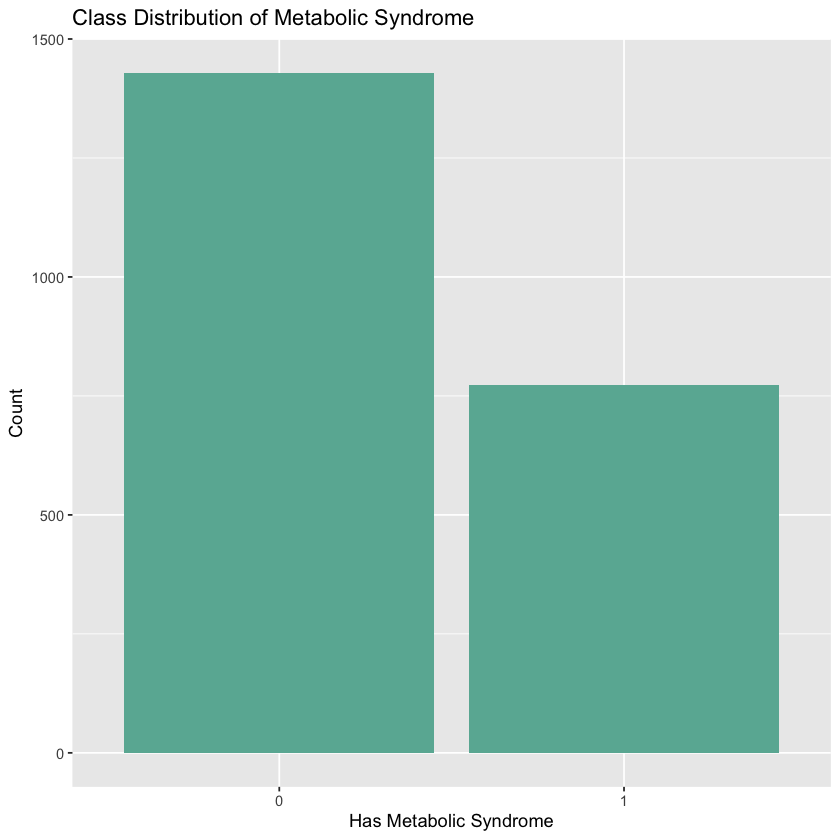

In [10]:
#Exploratory Data Analysis:

# Class distribution
table(met_data_clean$MetabolicSyndrome)

# Plot class balance
ggplot(met_data_clean, aes(x = MetabolicSyndrome)) +
  geom_bar(fill = "#69b3a2") +
  labs(title = "Class Distribution of Metabolic Syndrome", x = "Has Metabolic Syndrome", y = "Count")

In [12]:
# See structure of key columns
str(met_data_clean[, c("BMI", "Age", "BloodGlucose", "HDL", "Triglycerides", "WaistCirc")])

# Print out any entries that fail to coerce to numeric
for (col in c("BMI", "Age", "BloodGlucose", "HDL", "Triglycerides", "WaistCirc")) {
  bad_vals <- met_data_clean[[col]][is.na(suppressWarnings(as.numeric(met_data_clean[[col]])))]
  if (length(bad_vals)) {
    cat("Non-numeric in", col, ":\n")
    print(unique(bad_vals))
  } else {
    cat("All values in", col, "are numeric.\n")
  }
}

'data.frame':	2201 obs. of  6 variables:
 $ BMI          : num  23.3 23.2 20.1 33.3 28.5 22.1 22.4 28.2 28 24.7 ...
 $ Age          : int  22 44 21 43 80 26 30 35 57 36 ...
 $ BloodGlucose : int  92 82 107 104 105 87 83 94 100 94 ...
 $ HDL          : int  41 28 43 73 47 61 48 46 35 58 ...
 $ Triglycerides: int  84 56 78 141 100 40 91 86 98 182 ...
 $ WaistCirc    : num  81 80.1 69.6 120.4 112.5 ...
All values in BMI are numeric.
All values in Age are numeric.
All values in BloodGlucose are numeric.
All values in HDL are numeric.
All values in Triglycerides are numeric.
All values in WaistCirc are numeric.


In [24]:
colnames(met_data_clean)

[1] "seqn"              "Age"               "Sex"              
 [4] "Marital"           "Income"            "Race"             
 [7] "WaistCirc"         "BMI"               "Albuminuria"      
[10] "UrAlbCr"           "UricAcid"          "BloodGlucose"     
[13] "HDL"               "Triglycerides"     "MetabolicSyndrome"

In [13]:
# Count how many 0’s and 1’s remain
table(met_data_clean$MetabolicSyndrome)


   0    1 
1429  772 

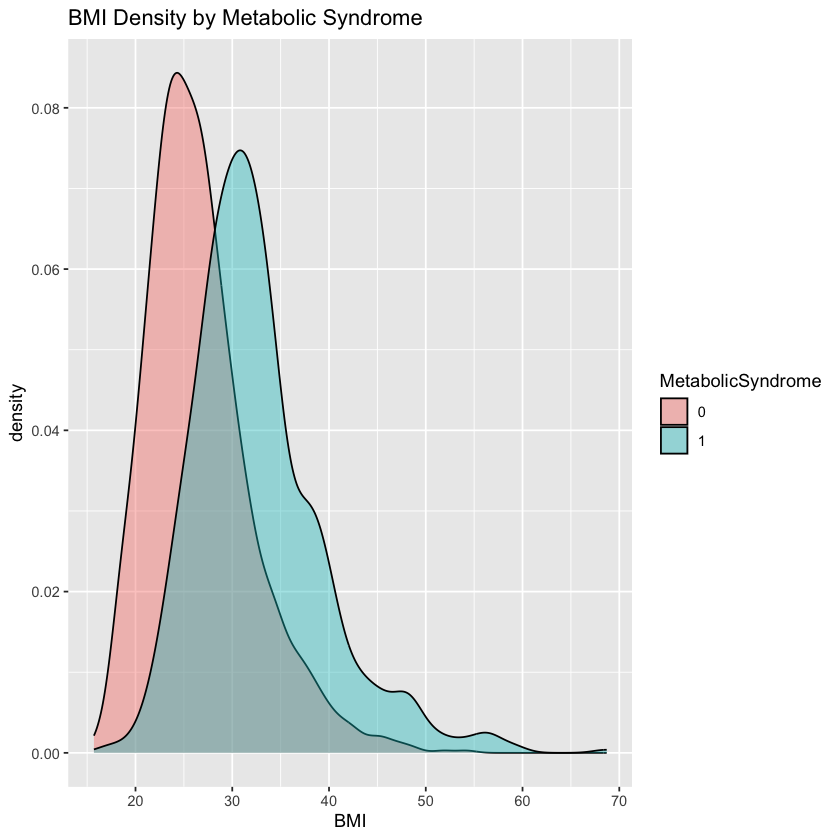

In [14]:
#Density Plots to show relationship with Metabolic Syndrome

#For BMI:
library(ggplot2)

ggplot(met_data_clean, aes(x = BMI, fill = MetabolicSyndrome)) +
  geom_density(alpha = 0.4) +
  labs(title = "BMI Density by Metabolic Syndrome")

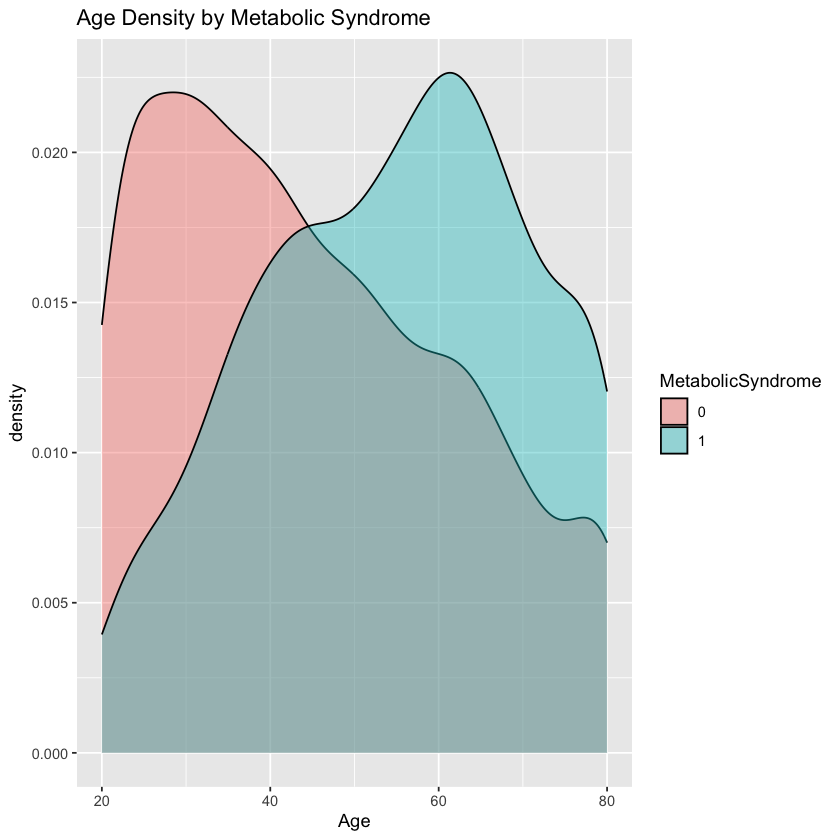

In [15]:
# For Age
ggplot(met_data_clean, aes(x = Age, fill = MetabolicSyndrome)) +
  geom_density(alpha = 0.4) +
  labs(title = "Age Density by Metabolic Syndrome")

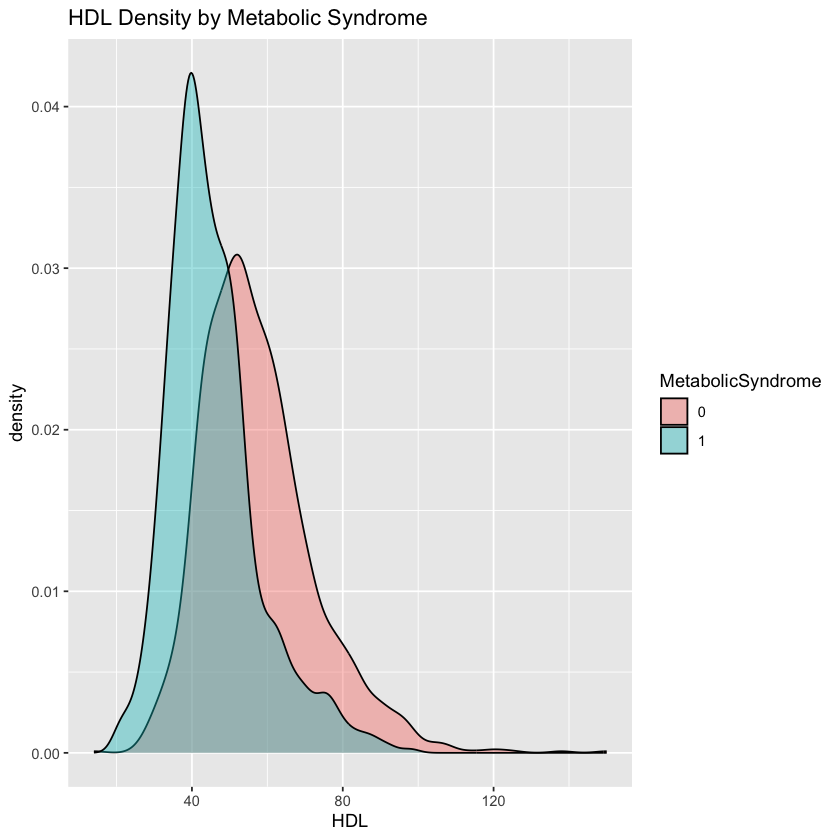

In [16]:
# For HDL
ggplot(met_data_clean, aes(x = HDL, fill = MetabolicSyndrome)) +
  geom_density(alpha = 0.4) +
  labs(title = "HDL Density by Metabolic Syndrome")

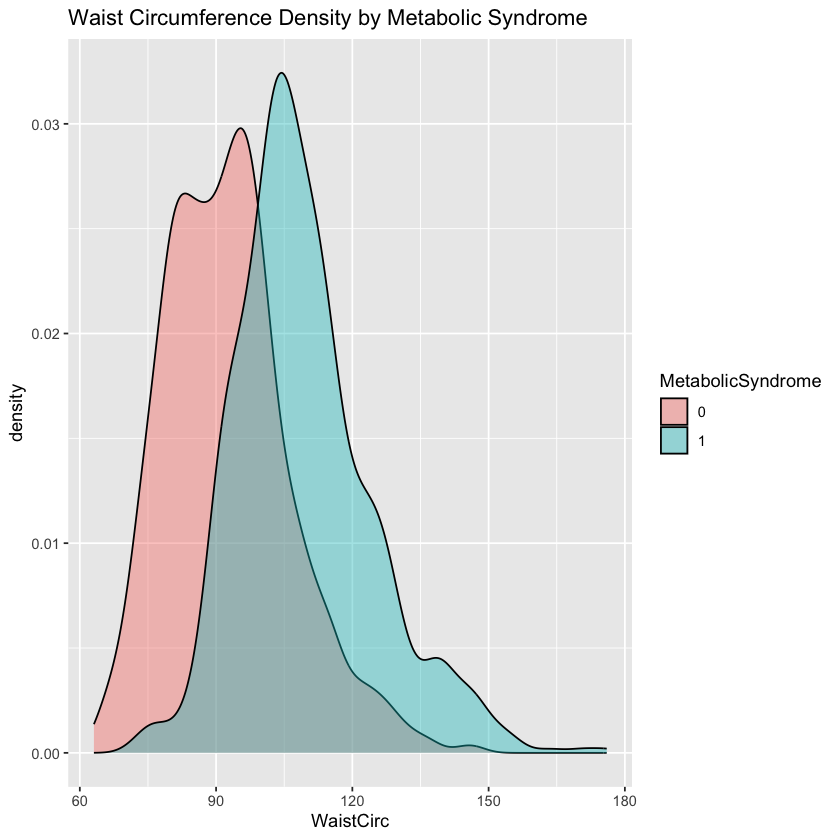

In [37]:
# For Waist Circumfrence
ggplot(met_data_clean, aes(x = WaistCirc, fill = MetabolicSyndrome)) +
  geom_density(alpha = 0.4) +
  labs(title = "Waist Circumference Density by Metabolic Syndrome")

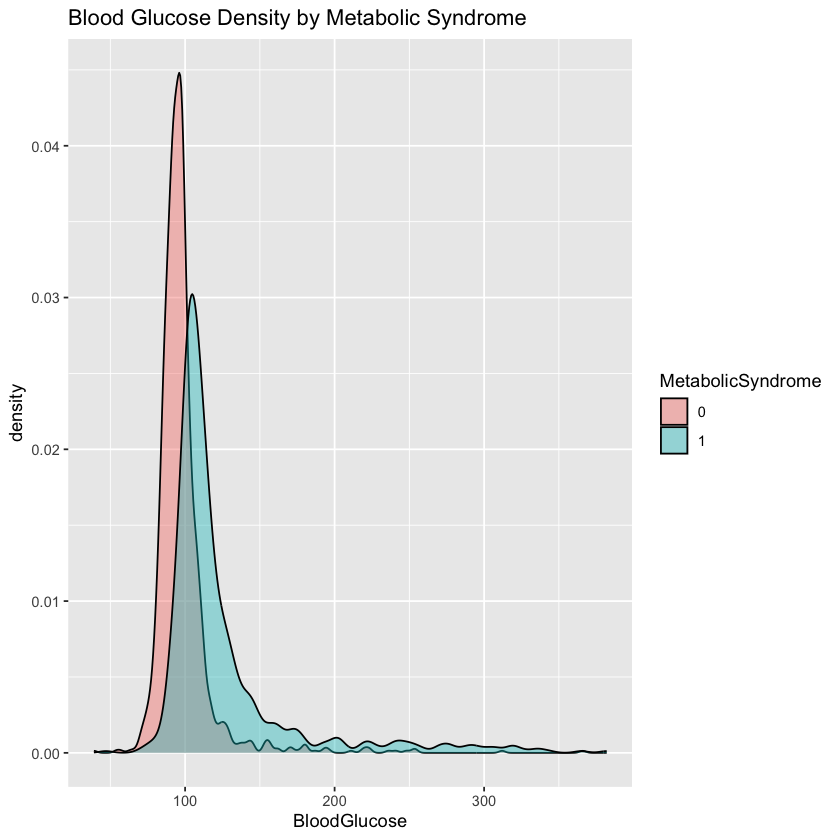

In [17]:
# For Blood Glucose
ggplot(met_data_clean, aes(x = BloodGlucose, fill = MetabolicSyndrome)) +
  geom_density(alpha = 0.4) +
  labs(title = "Blood Glucose Density by Metabolic Syndrome")

In [33]:
summary(met_data_clean$BloodGlucose)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   39.0    92.0    99.0   107.8   110.0   382.0 

In [ ]:
#Observation: Very right-skewed for both classes. Those with MS (class 1) show a strong right tail, suggesting elevated glucose levels.

#To reduce skew and improve model behavior, we applied a log transformation and created a new variable, LogBloodGlucose

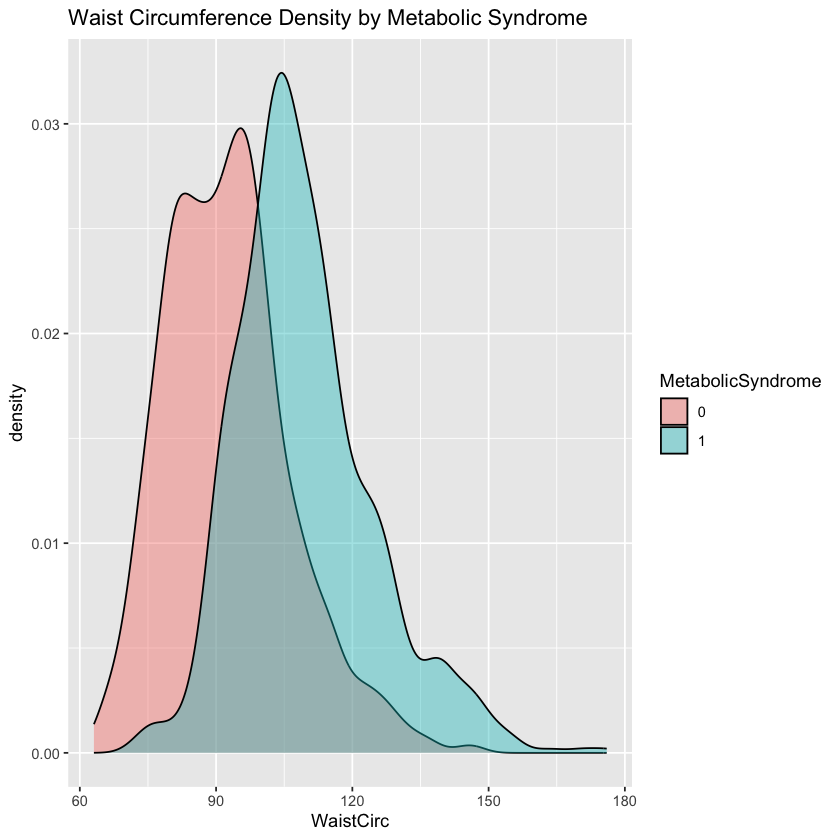

In [20]:
# For Waist Circumference
ggplot(met_data_clean, aes(x = WaistCirc, fill = MetabolicSyndrome)) +
  geom_density(alpha = 0.4) +
  labs(title = "Waist Circumference Density by Metabolic Syndrome")

In [34]:
met_data_clean <- met_data_clean %>%
  mutate(LogBloodGlucose = log(BloodGlucose))

In [35]:
summary(met_data_clean$LogBloodGlucose)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.664   4.522   4.595   4.648   4.700   5.945 

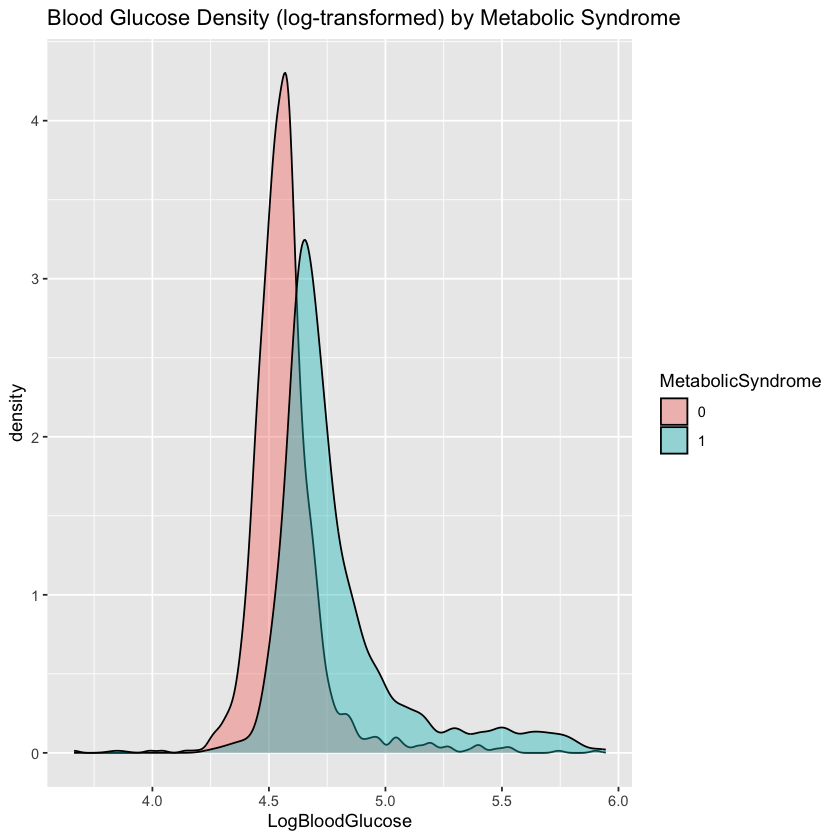

In [36]:
#Rerun improved desnity plot for Blood Glucose

ggplot(met_data_clean, aes(x = LogBloodGlucose, fill = MetabolicSyndrome)) +
  geom_density(alpha = 0.4) +
  labs(title = "Blood Glucose Density (log-transformed) by Metabolic Syndrome")

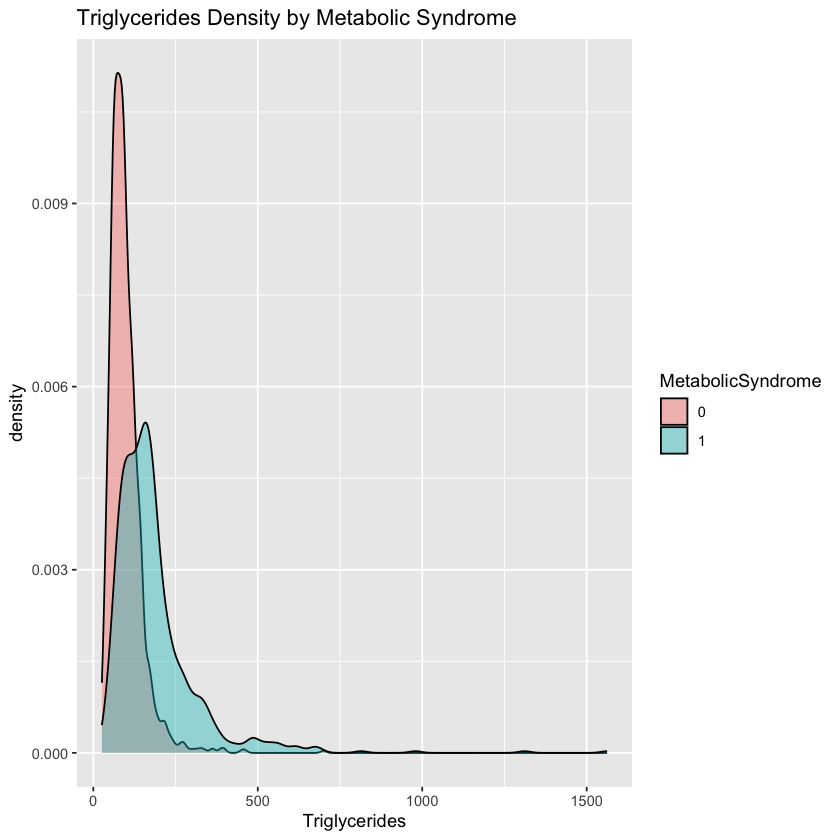

In [21]:
# For Triglycerides
ggplot(met_data_clean, aes(x = Triglycerides, fill = MetabolicSyndrome)) +
  geom_density(alpha = 0.4) +
  labs(title = "Triglycerides Density by Metabolic Syndrome")

In [27]:
summary(met_data_clean$Triglycerides)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   26.0    75.0   103.0   128.2   150.0  1562.0 

In [27]:
summary(met_data_clean$Triglycerides)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   26.0    75.0   103.0   128.2   150.0  1562.0 

In [ ]:
#Triglyceride levels in the dataset were highly skewed, with extreme outliers present (median ≈ 103, max ≈ 1562). 
#To reduce the impact of outliers and normalize the distribution, we applied a log transformation and created a new variable, LogTriglycerides, which was used for EDA and modeling purposes.

In [29]:
met_data_clean <- met_data_clean %>%
  mutate(LogTriglycerides = log(Triglycerides))

In [30]:
summary(met_data_clean$LogTriglycerides)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.258   4.317   4.635   4.683   5.011   7.354 

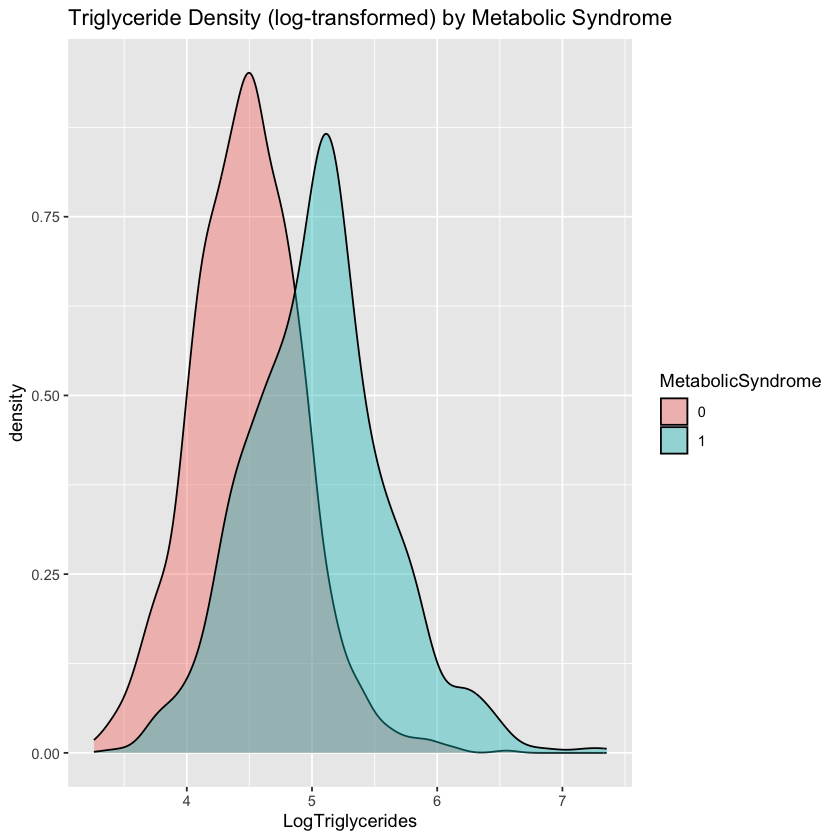

In [32]:
#Rerun improved desnity plot for Triglycerides

ggplot(met_data_clean, aes(x = LogTriglycerides, fill = MetabolicSyndrome)) +
  geom_density(alpha = 0.4) +
  labs(title = "Triglyceride Density (log-transformed) by Metabolic Syndrome")

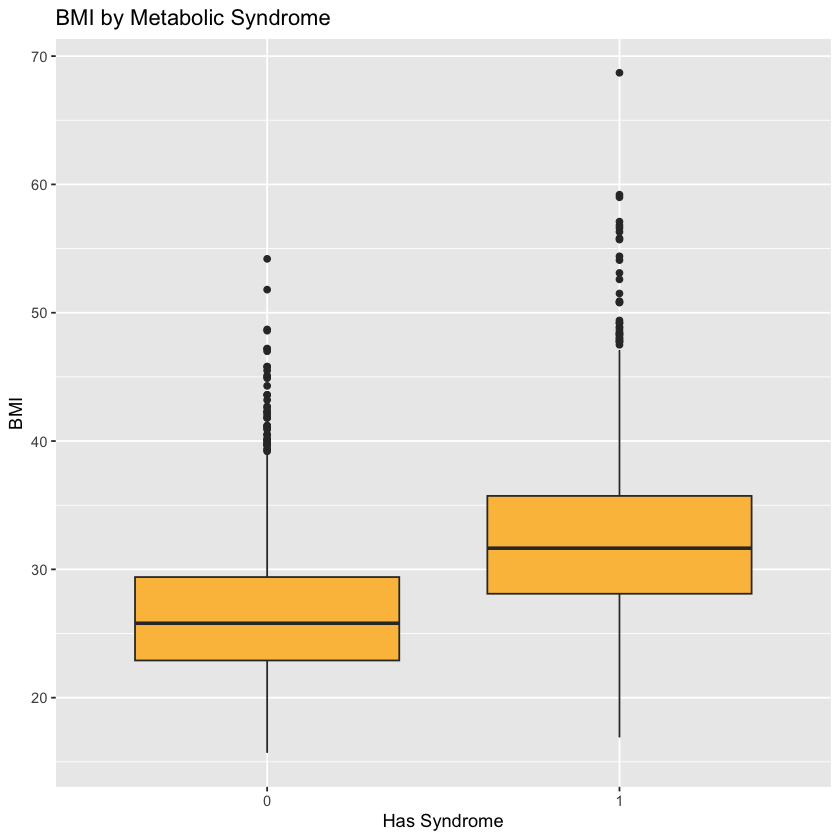

In [16]:
#Boxplots to show median, IQR, and outliers between classes:

#For BMI

ggplot(met_data_clean, aes(x = MetabolicSyndrome, y = BMI)) +
  geom_boxplot(fill = "#fcbf49") +
  labs(title = "BMI by Metabolic Syndrome", x = "Has Syndrome", y = "BMI")

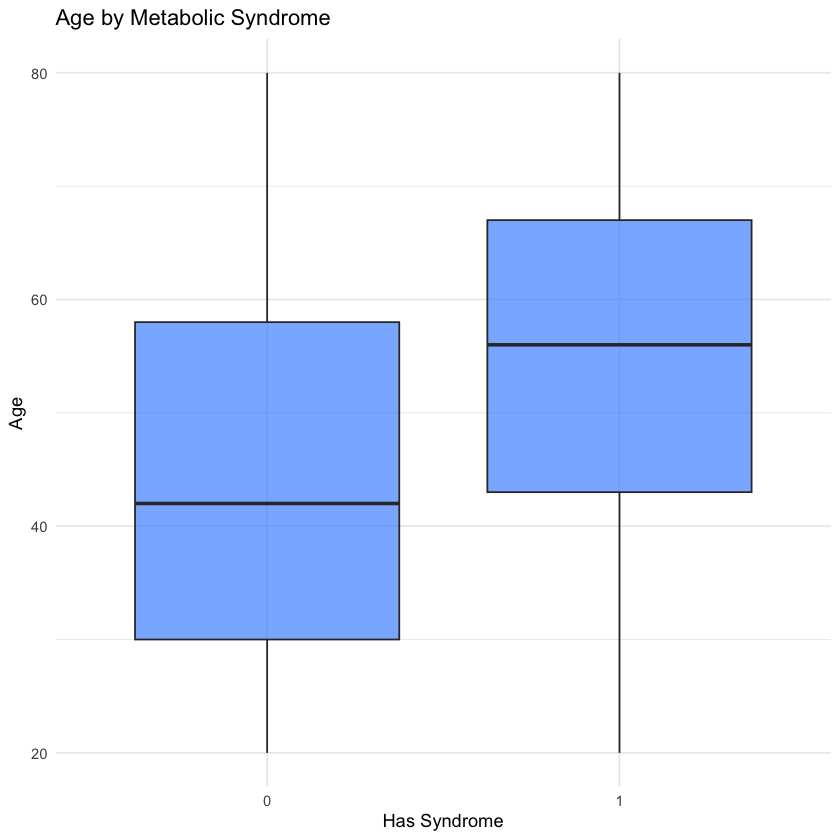

In [17]:
#For Age

ggplot(met_data_clean, aes(x = MetabolicSyndrome, y = Age)) +
  geom_boxplot(fill = "#4D96FF", alpha = 0.7) +
  labs(title = "Age by Metabolic Syndrome", x = "Has Syndrome", y = "Age") +
  theme_minimal()

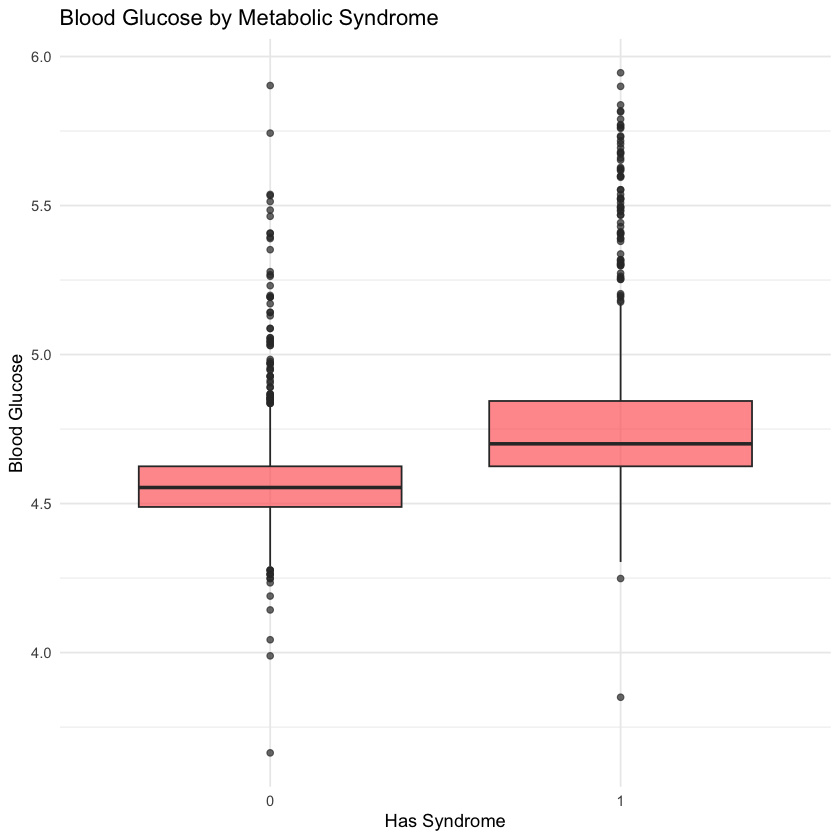

In [38]:
#For (Log)Blood Glucose

ggplot(met_data_clean, aes(x = MetabolicSyndrome, y = LogBloodGlucose)) +
  geom_boxplot(fill = "#FF6B6B", alpha = 0.7) +
  labs(title = "Blood Glucose by Metabolic Syndrome", x = "Has Syndrome", y = "Blood Glucose") +
  theme_minimal()

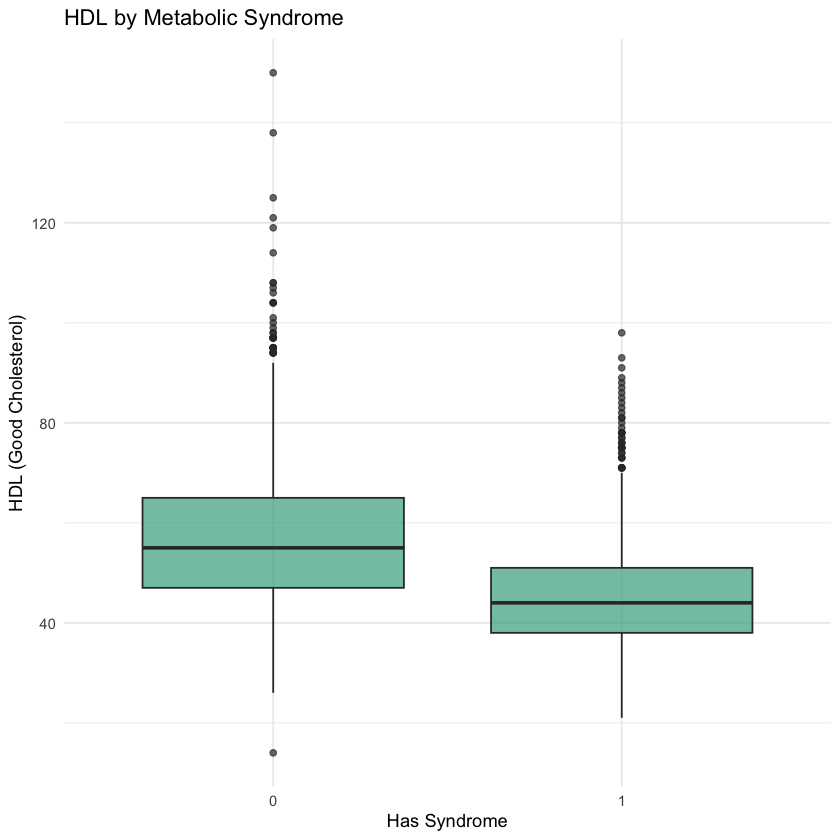

In [19]:
#For HDL (good cholesterol)

ggplot(met_data_clean, aes(x = MetabolicSyndrome, y = HDL)) +
  geom_boxplot(fill = "#43AA8B", alpha = 0.7) +
  labs(title = "HDL by Metabolic Syndrome", x = "Has Syndrome", y = "HDL (Good Cholesterol)") +
  theme_minimal()

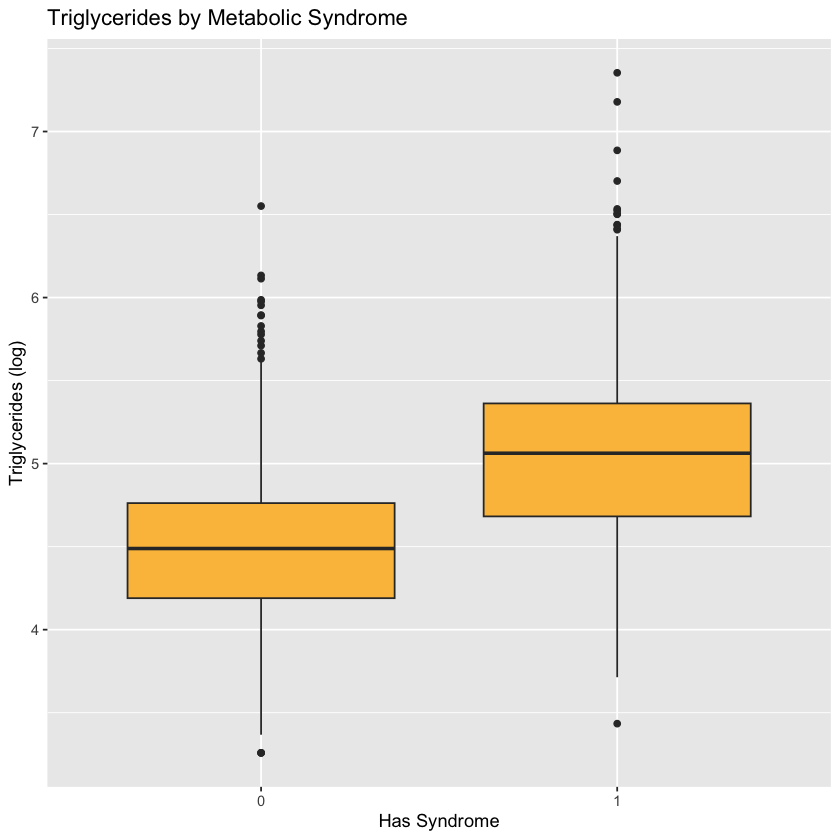

In [43]:
# For log(Triglycerides)
ggplot(met_data_clean, aes(x = MetabolicSyndrome, y = LogTriglycerides)) +
  geom_boxplot(fill = "#fcbf49") +
  labs(
    title = "Triglycerides by Metabolic Syndrome",
    x = "Has Syndrome",
    y = "Triglycerides (log)"
  )

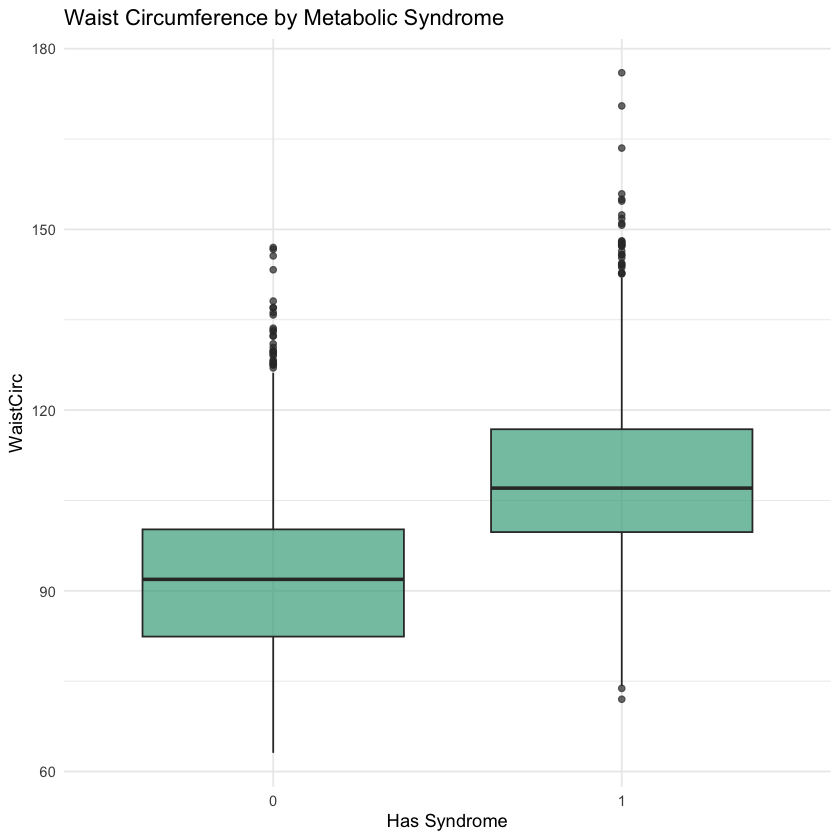

In [44]:
#For Waist Circumference

ggplot(met_data_clean, aes(x = MetabolicSyndrome, y = WaistCirc)) +
  geom_boxplot(fill = "#43AA8B", alpha = 0.7) +
  labs(title = "Waist Circumference by Metabolic Syndrome", x = "Has Syndrome", y = "WaistCirc") +
  theme_minimal()

In [56]:
library(ggplot2)

# p1: BMI
p1 <- ggplot(met_data_clean, aes(x = MetabolicSyndrome, y = BMI)) +
  geom_boxplot(fill = "#fcbf49") +
  labs(title = "BMI by Metabolic Syndrome", x = "Has Syndrome", y = "BMI") +
  theme_minimal()

# p2: Age
p2 <- ggplot(met_data_clean, aes(x = MetabolicSyndrome, y = Age)) +
  geom_boxplot(fill = "#4dabf7") +
  labs(title = "Age by Metabolic Syndrome", x = "Has Syndrome", y = "Age") +
  theme_minimal()

# p3: Blood Glucose
p3 <- ggplot(met_data_clean, aes(x = MetabolicSyndrome, y = LogBloodGlucose)) +
  geom_boxplot(fill = "#ff6b6b") +
  labs(title = "Log Blood Glucose by Metabolic Syndrome", x = "Has Syndrome", y = "Log(Blood Glucose)") +
  theme_minimal()

# p4: HDL
p4 <- ggplot(met_data_clean, aes(x = MetabolicSyndrome, y = HDL)) +
  geom_boxplot(fill = "#69db7c") +
  labs(title = "HDL by Metabolic Syndrome", x = "Has Syndrome", y = "HDL") +
  theme_minimal()

# p5: Waist Circumference
p5 <- ggplot(met_data_clean, aes(x = MetabolicSyndrome, y = WaistCirc)) +
  geom_boxplot(fill = "#74c0fc") +
  labs(title = "Waist Circumference by Metabolic Syndrome", x = "Has Syndrome", y = "WaistCirc") +
  theme_minimal()

# p6: Triglycerides (log)
p6 <- ggplot(met_data_clean, aes(x = MetabolicSyndrome, y = LogTriglycerides)) +
  geom_boxplot(fill = "#ffd43b") +
  labs(title = "Triglycerides (log) by Metabolic Syndrome", x = "Has Syndrome", y = "Triglycerides (log)") +
  theme_minimal()

In [60]:
# 3 columns x 2 rows grid of all box plots
combined_plot <- (p1 | p2 | p3) / 
                 (p4 | p5 | p6) +
                 plot_layout(guides = "collect") &
                 ggplot2::theme(plot.margin = grid::unit(c(10, 10, 10, 10), "pt"))

In [61]:
ggsave("combined_boxplots_3x2.png", combined_plot, width = 14, height = 8, dpi = 300)

In [62]:
#Train/Test split data

# Set seed for reproducibility
set.seed(123)

# Create stratified train/test split (80/20)
split_index <- createDataPartition(met_data_clean$MetabolicSyndrome, p = 0.8, list = FALSE)

# Split into train and test
train_data <- met_data_clean[split_index, ]
test_data  <- met_data_clean[-split_index, ]

# Check class distribution in both sets
prop.table(table(train_data$MetabolicSyndrome))
prop.table(table(test_data$MetabolicSyndrome))


        0         1 
0.6492622 0.3507378 


        0         1 
0.6492027 0.3507973 

In [63]:
#Model building

#1: Logistic Regression Model

# Build logistic regression model on training data
logit_model <- glm(MetabolicSyndrome ~ BMI + Age + LogBloodGlucose + HDL + 
                   WaistCirc + LogTriglycerides, 
                   data = train_data, family = binomial)


# Model summary
summary(logit_model)


Call:
glm(formula = MetabolicSyndrome ~ BMI + Age + LogBloodGlucose + 
    HDL + WaistCirc + LogTriglycerides, family = binomial, data = train_data)

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -38.415102   2.624706 -14.636  < 2e-16 ***
BMI                0.124029   0.027068   4.582 4.60e-06 ***
Age                0.037119   0.004932   7.526 5.24e-14 ***
LogBloodGlucose    4.585695   0.467964   9.799  < 2e-16 ***
HDL               -0.034567   0.006762  -5.112 3.19e-07 ***
WaistCirc          0.020902   0.011524   1.814   0.0697 .  
LogTriglycerides   2.218997   0.183475  12.094  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2283.2  on 1761  degrees of freedom
Residual deviance: 1219.6  on 1755  degrees of freedom
AIC: 1233.6

Number of Fisher Scoring iterations: 6


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 248  37
         1  37 117
                                          
               Accuracy : 0.8314          
                 95% CI : (0.7931, 0.8653)
    No Information Rate : 0.6492          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.6299          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.7597          
            Specificity : 0.8702          
         Pos Pred Value : 0.7597          
         Neg Pred Value : 0.8702          
             Prevalence : 0.3508          
         Detection Rate : 0.2665          
   Detection Prevalence : 0.3508          
      Balanced Accuracy : 0.8150          
                                          
       'Positive' Class : 1               
                              

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.9056


Cohen’s Kappa: 0.6299157 
95% CI for Accuracy: 0.793 0.865 


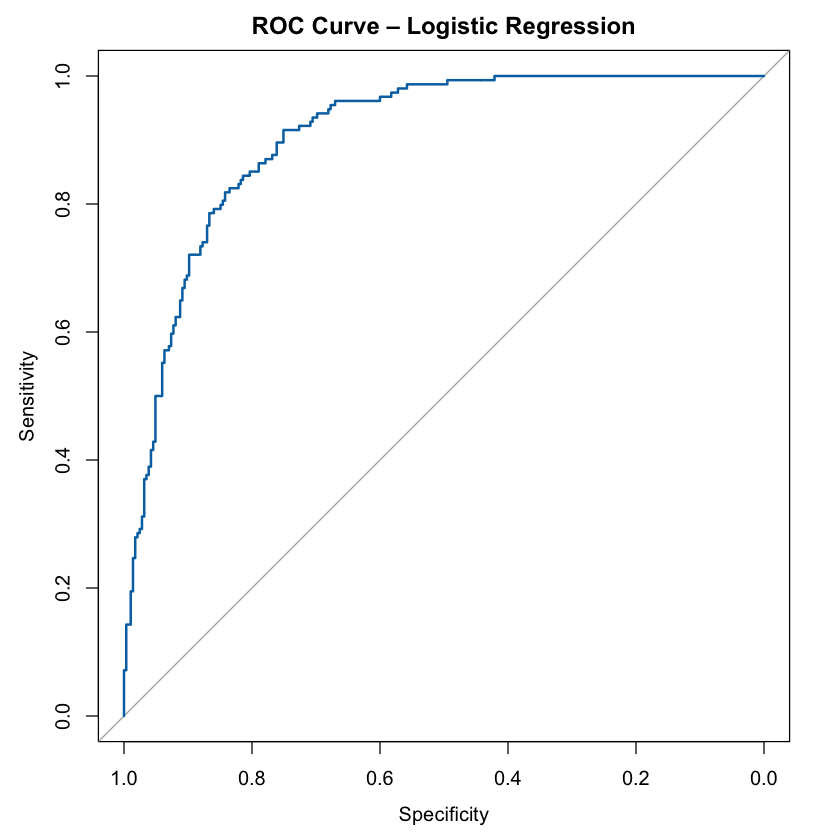

In [66]:
#Evaluate the Logistic Regression Model

# Predict probabilities
logit_probs <- predict(logit_model, newdata = test_data, type = "response")

# Convert to class (threshold = 0.5)
logit_preds <- ifelse(logit_probs > 0.5, 1, 0)

# Convert to factors
logit_preds <- factor(logit_preds, levels = c(0, 1))
true_labels <- factor(test_data$MetabolicSyndrome, levels = c(0, 1))

# Confusion matrix
conf_mat <- confusionMatrix(logit_preds, true_labels, positive = "1")
print(conf_mat)

# ROC Curve & AUC
roc_logit <- roc(true_labels, logit_probs)
plot(roc_logit, col = "#0072B2", lwd = 2, main = "ROC Curve – Logistic Regression")
auc(roc_logit)

# Cohen's Kappa
kappa_val <- conf_mat$overall["Kappa"]
cat("\nCohen’s Kappa:", kappa_val, "\n")

# 95% CI for Accuracy
ci <- conf_mat$overall[c("AccuracyLower", "AccuracyUpper")]
cat("95% CI for Accuracy:", round(ci, 3), "\n")


Call:
 randomForest(formula = MetabolicSyndrome ~ BMI + Age + LogBloodGlucose +      HDL + WaistCirc + LogTriglycerides, data = train_data, ntree = 500,      mtry = 2, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 12.6%
Confusion matrix:
     0   1 class.error
0 1039 105  0.09178322
1  117 501  0.18932039


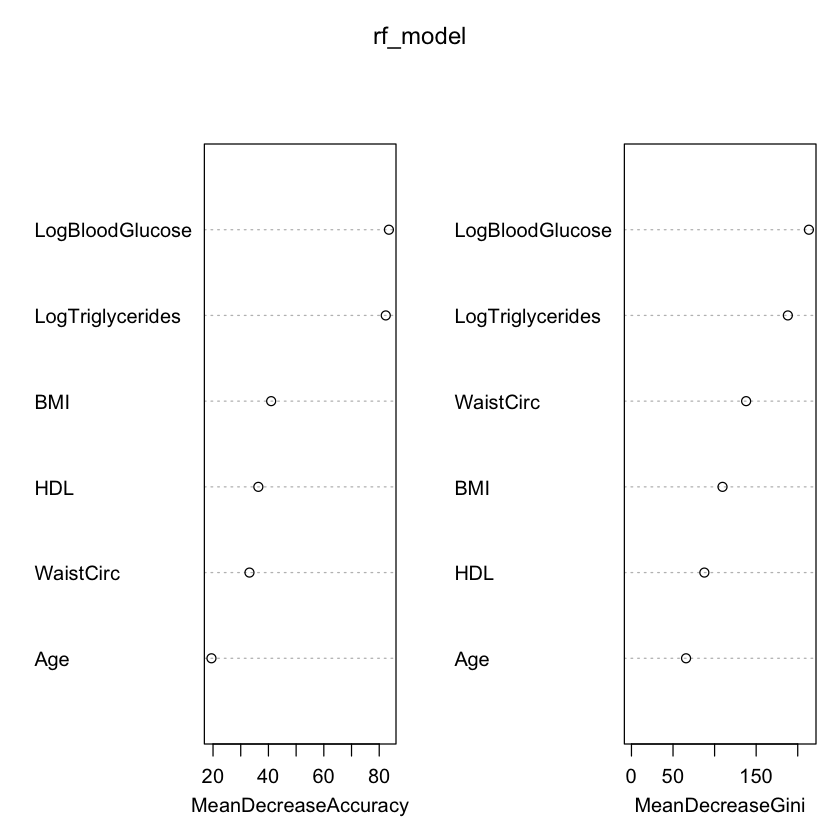

In [67]:
#2: Random Forest Model

# Random Forest using all 6 selected predictors
rf_model <- randomForest(MetabolicSyndrome ~ BMI + Age + LogBloodGlucose + HDL + WaistCirc + LogTriglycerides,
                         data = train_data,
                         ntree = 500,
                         mtry = 2, 
                         importance = TRUE)
print(rf_model)

varImpPlot(rf_model)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 249  27
         1  36 127
                                          
               Accuracy : 0.8565          
                 95% CI : (0.8202, 0.8879)
    No Information Rate : 0.6492          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.6891          
                                          
 Mcnemar's Test P-Value : 0.3135          
                                          
            Sensitivity : 0.8247          
            Specificity : 0.8737          
         Pos Pred Value : 0.7791          
         Neg Pred Value : 0.9022          
             Prevalence : 0.3508          
         Detection Rate : 0.2893          
   Detection Prevalence : 0.3713          
      Balanced Accuracy : 0.8492          
                                          
       'Positive' Class : 1               
                              

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.9434

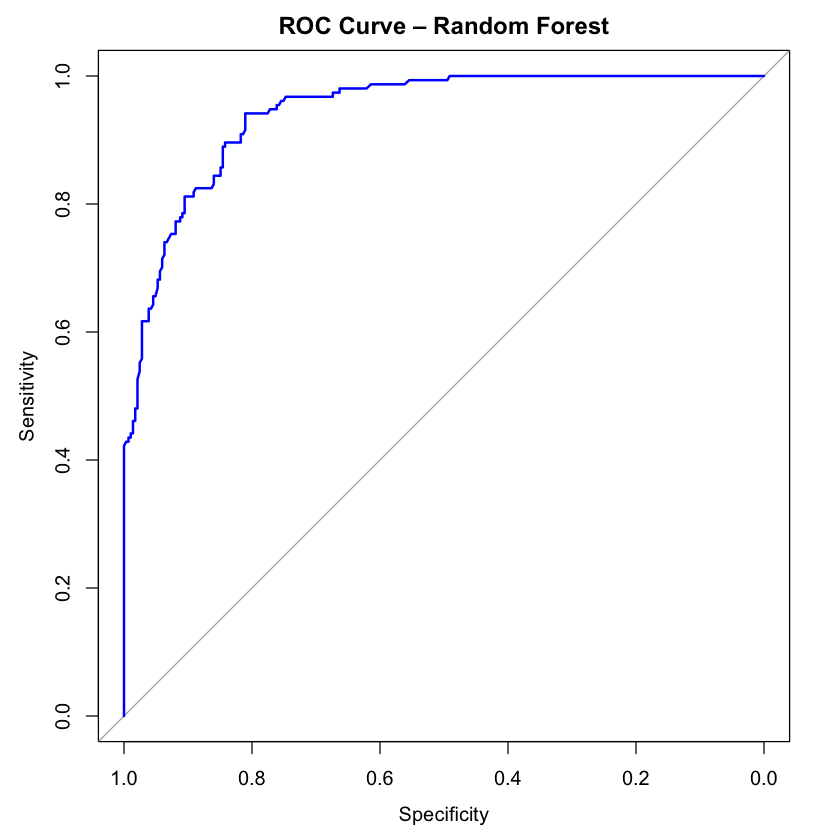

In [68]:
# Predict on test set
rf_preds <- predict(rf_model, newdata = test_data)

# Confusion Matrix
conf_matrix_rf <- confusionMatrix(rf_preds, test_data$MetabolicSyndrome, positive = "1")
print(conf_matrix_rf)

# ROC Curve
rf_probs <- predict(rf_model, newdata = test_data, type = "prob")[,2]
roc_rf <- roc(test_data$MetabolicSyndrome, rf_probs)

plot(roc_rf, main = "ROC Curve – Random Forest", col = "blue", lwd = 2)
auc(roc_rf)

In [70]:
train_data$MetabolicSyndrome <- factor(train_data$MetabolicSyndrome, levels = c(0, 1), labels = c("No", "Yes"))
test_data$MetabolicSyndrome <- factor(test_data$MetabolicSyndrome, levels = c(0, 1), labels = c("No", "Yes"))

Random Forest 

1762 samples
   6 predictor
   2 classes: 'No', 'Yes' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1410, 1409, 1409, 1411, 1409 
Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec     
  1     0.9459872  0.9108098  0.7750590
  2     0.9464760  0.9029342  0.7912667
  3     0.9450083  0.9003218  0.8009966
  4     0.9433262  0.9003218  0.8042355
  5     0.9418668  0.9003179  0.7993706
  6     0.9407586  0.8959473  0.7961317

ROC was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.


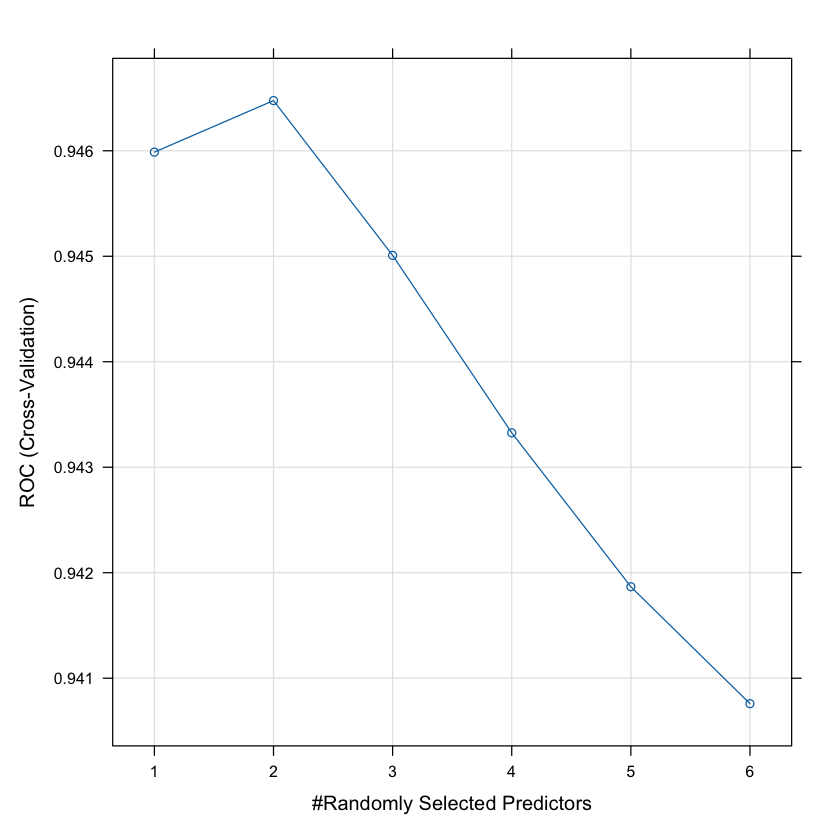

In [71]:
#Hyperparameter Tuning for Random Forest

# Set tuning grid for mtry
tune_grid <- expand.grid(mtry = c(1, 2, 3, 4, 5, 6))

# Cross-validation setup
ctrl <- trainControl(
  method = "cv",
  number = 5,
  classProbs = TRUE,
  summaryFunction = twoClassSummary,
  savePredictions = TRUE
)

# Train tuned RF model
set.seed(123)
rf_tuned <- train(
  MetabolicSyndrome ~ BMI + Age + LogBloodGlucose + HDL + WaistCirc + LogTriglycerides,
  data = train_data,
  method = "rf",
  trControl = ctrl,
  tuneGrid = tune_grid,
  metric = "ROC"
)

#show best model
print(rf_tuned)
plot(rf_tuned)

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  249  27
       Yes  36 127
                                          
               Accuracy : 0.8565          
                 95% CI : (0.8202, 0.8879)
    No Information Rate : 0.6492          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.6891          
                                          
 Mcnemar's Test P-Value : 0.3135          
                                          
            Sensitivity : 0.8247          
            Specificity : 0.8737          
         Pos Pred Value : 0.7791          
         Neg Pred Value : 0.9022          
             Prevalence : 0.3508          
         Detection Rate : 0.2893          
   Detection Prevalence : 0.3713          
      Balanced Accuracy : 0.8492          
                                          
       'Positive' Class : Yes             
                              

Setting levels: control = No, case = Yes

Setting direction: controls < cases



Area under the curve: 0.9428

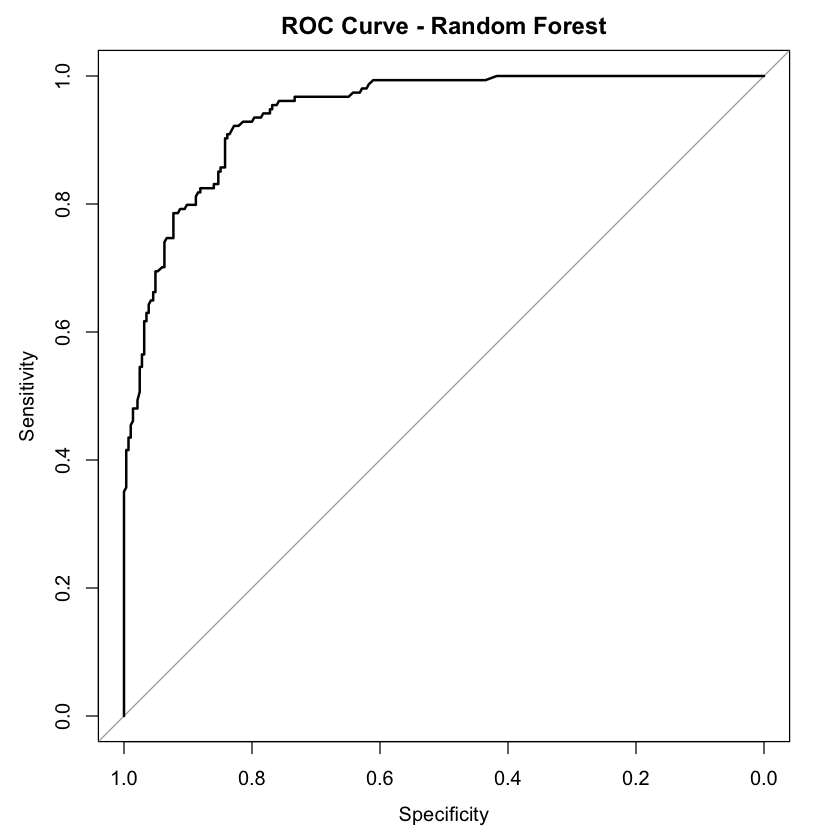

In [72]:
#Final evaluation on test data

# Predict on test data
rf_preds <- predict(rf_tuned, newdata = test_data)
rf_probs <- predict(rf_tuned, newdata = test_data, type = "prob")

# Confusion matrix and metrics
conf_rf <- confusionMatrix(rf_preds, test_data$MetabolicSyndrome, positive = "Yes")
print(conf_rf)

# ROC Curve
library(pROC)
rf_roc <- roc(response = test_data$MetabolicSyndrome,
              predictor = rf_probs$Yes)
plot(rf_roc, main = "ROC Curve - Random Forest")
auc(rf_roc)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.8972

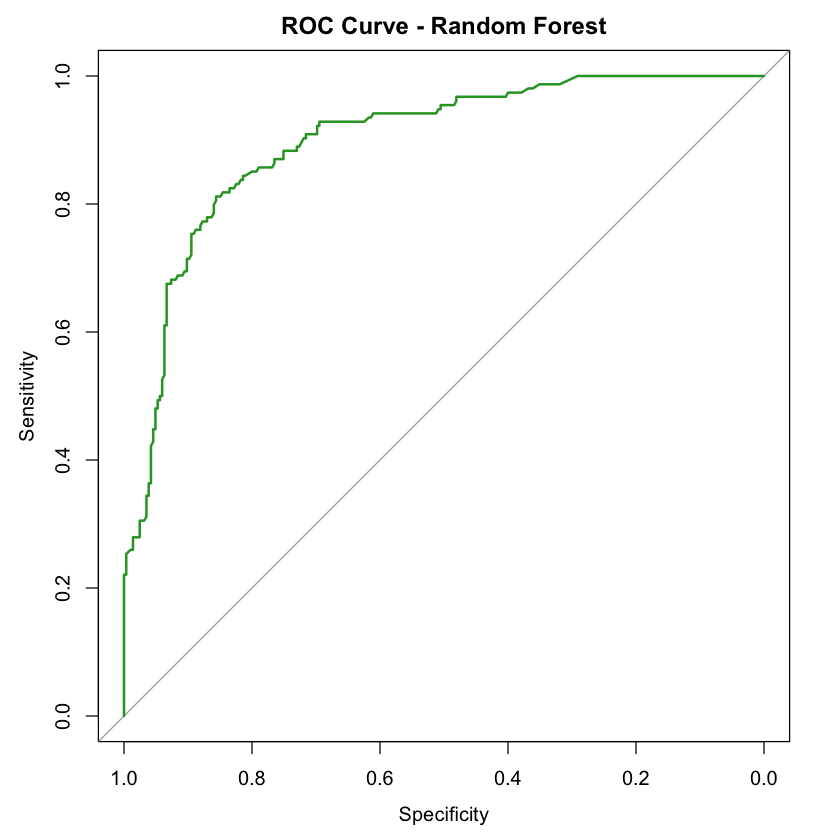

In [33]:
#ROC Curve + AUC comparison

# predicted probabilities for class 1
rf_probs <- predict(rf_model, newdata = test_data, type = "prob")[,2]

# Plot ROC
rf_roc <- roc(test_data$MetabolicSyndrome, rf_probs)
plot(rf_roc, col = "#2ca02c", lwd = 2, main = "ROC Curve - Random Forest")
auc(rf_roc)

Random Forest 

1762 samples
   4 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1409, 1410, 1409, 1411, 1409 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
  2     0.8246438  0.6093257
  3     0.8184018  0.5959628
  4     0.8155657  0.5895011

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.


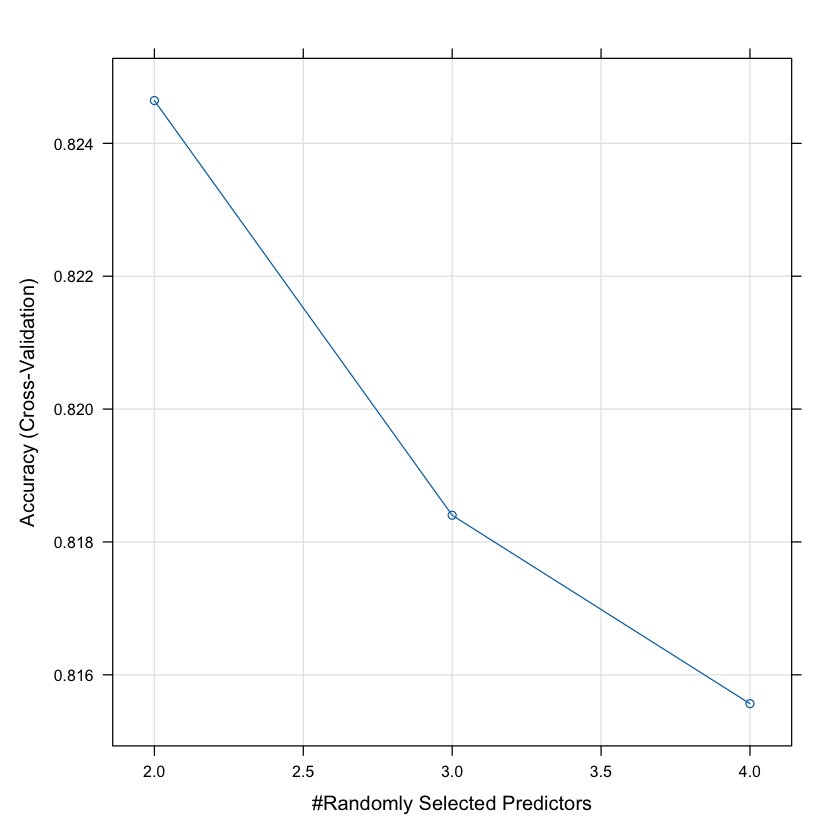

In [34]:
#Random Forest Hyperparameter Tuning

# Define training control with 5-fold cross-validation
ctrl <- trainControl(method = "cv", number = 5)

# Define tuning grid
tune_grid <- expand.grid(
  mtry = c(2, 3, 4)  # Number of predictors to try at each split
)

# Run grid search with caret::train
rf_tuned <- train(
  MetabolicSyndrome ~ BMI + Age + BloodGlucose + HDL,
  data = train_data,
  method = "rf",
  metric = "Accuracy",
  trControl = ctrl,
  tuneGrid = tune_grid,
  ntree = 500
)

print(rf_tuned)
plot(rf_tuned)

In [75]:
#SVM model

# Define tuning grid & control

# Set up cross-validation
ctrl <- trainControl(method = "cv", number = 5, 
                     classProbs = TRUE,
                     summaryFunction = twoClassSummary,
                     savePredictions = "final")

# Tuning grid for cost (C) and RBF kernel sigma
svm_grid <- expand.grid(C = 2^(-1:2), sigma = 2^(-6:-2))

In [73]:
# Saving tuned Random Forest model to an .RData file
save(rf_tuned, file = "rf_model.RData")

Support Vector Machines with Radial Basis Function Kernel 

1762 samples
   6 predictor
   2 classes: 'No', 'Yes' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1409, 1409, 1411, 1409, 1410 
Resampling results across tuning parameters:

  C    sigma     ROC        Sens       Spec     
  0.5  0.015625  0.9193343  0.8985904  0.7476790
  0.5  0.031250  0.9222966  0.9020953  0.7476528
  0.5  0.062500  0.9267848  0.9090860  0.7444270
  0.5  0.125000  0.9303818  0.9073393  0.7508786
  0.5  0.250000  0.9282474  0.9099594  0.7476397
  1.0  0.015625  0.9208042  0.9047116  0.7411880
  1.0  0.031250  0.9242912  0.9055888  0.7411749
  1.0  0.062500  0.9291080  0.9082165  0.7508786
  1.0  0.125000  0.9315993  0.9125871  0.7524915
  1.0  0.250000  0.9273669  0.9134682  0.7541306
  2.0  0.015625  0.9221191  0.9073393  0.7395620
  2.0  0.031250  0.9265194  0.9108328  0.7444270
  2.0  0.062500  0.9306199  0.9117023  0.7508917
  2.0  0.125000  0.9318795  0.9160883  0.

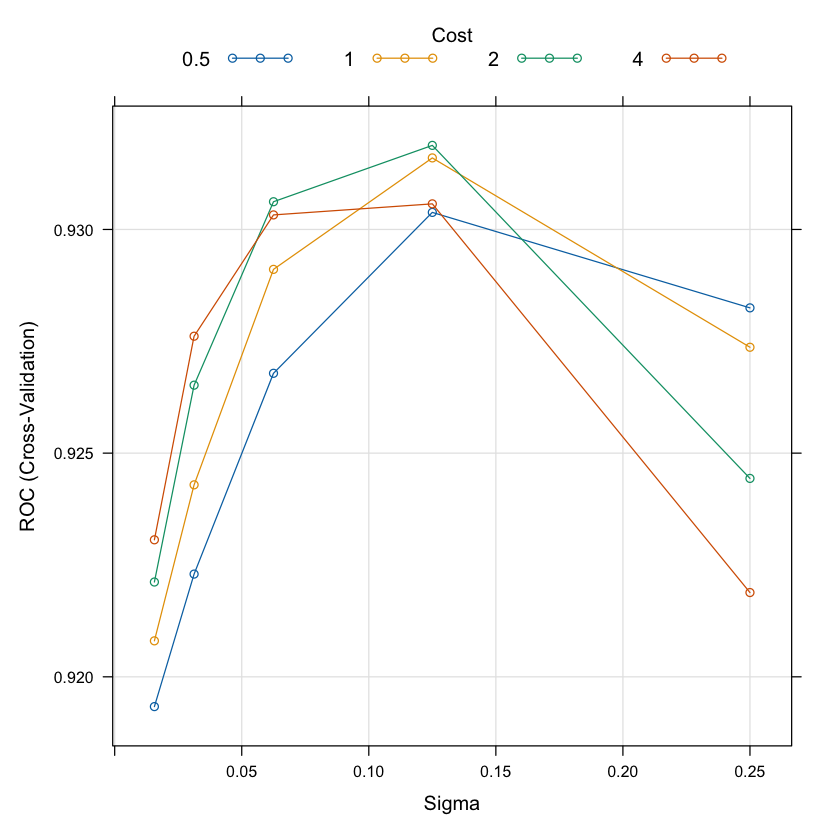

In [77]:
# Train SVM with RBF kernel
svm_model <- train(
  MetabolicSyndrome ~ BMI + Age + LogBloodGlucose + HDL + WaistCirc + LogTriglycerides,
  data = train_data,
  method = "svmRadial",
  metric = "ROC",
  tuneGrid = svm_grid,
  trControl = ctrl
)

print(svm_model)
plot(svm_model)

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  252  31
       Yes  33 123
                                          
               Accuracy : 0.8542          
                 95% CI : (0.8177, 0.8859)
    No Information Rate : 0.6492          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.6809          
                                          
 Mcnemar's Test P-Value : 0.9005          
                                          
            Sensitivity : 0.7987          
            Specificity : 0.8842          
         Pos Pred Value : 0.7885          
         Neg Pred Value : 0.8905          
             Prevalence : 0.3508          
         Detection Rate : 0.2802          
   Detection Prevalence : 0.3554          
      Balanced Accuracy : 0.8415          
                                          
       'Positive' Class : Yes             
                              

Setting direction: controls < cases



Area under the curve: 0.9191

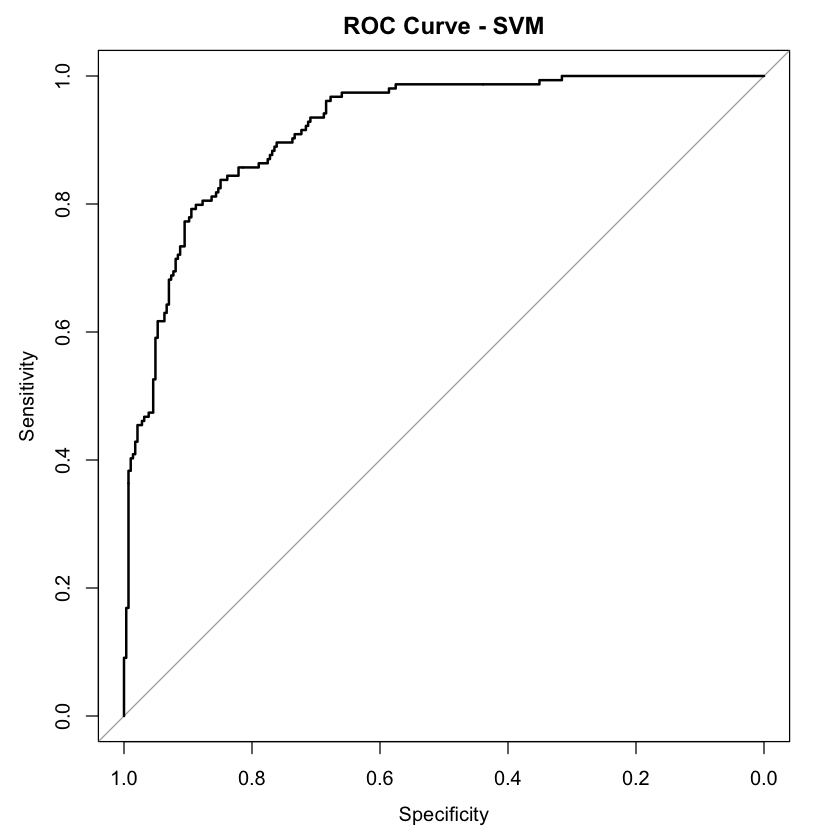

In [78]:
# Predict on test set
svm_preds <- predict(svm_model, newdata = test_data)
svm_probs <- predict(svm_model, newdata = test_data, type = "prob")

# Confusion matrix
confusionMatrix(svm_preds, test_data$MetabolicSyndrome, positive = "Yes")

# ROC curve
library(pROC)
svm_roc <- roc(test_data$MetabolicSyndrome, svm_probs$Yes, levels = c("No", "Yes"))
plot(svm_roc, main = "ROC Curve - SVM")
auc(svm_roc)

In [81]:
#K-Nearest Neighbors (KNN) model

# Define predictor variable names
predictors <- c("BMI", "Age", "LogBloodGlucose", "HDL", "WaistCirc", "LogTriglycerides")

k-Nearest Neighbors 

1762 samples
   6 predictor
   2 classes: 'No', 'Yes' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1410, 1409, 1409, 1411, 1409 
Resampling results across tuning parameters:

  k   ROC        Sens       Spec     
   3  0.8755211  0.8819620  0.7297666
   5  0.8999051  0.8942121  0.7345660
   7  0.9141732  0.8968283  0.7458956
   9  0.9206517  0.8977132  0.7427223
  11  0.9250012  0.9020762  0.7410700
  13  0.9275151  0.9073316  0.7378704
  15  0.9282622  0.9125488  0.7394833

ROC was used to select the optimal model using the largest value.
The final value used for the model was k = 15.


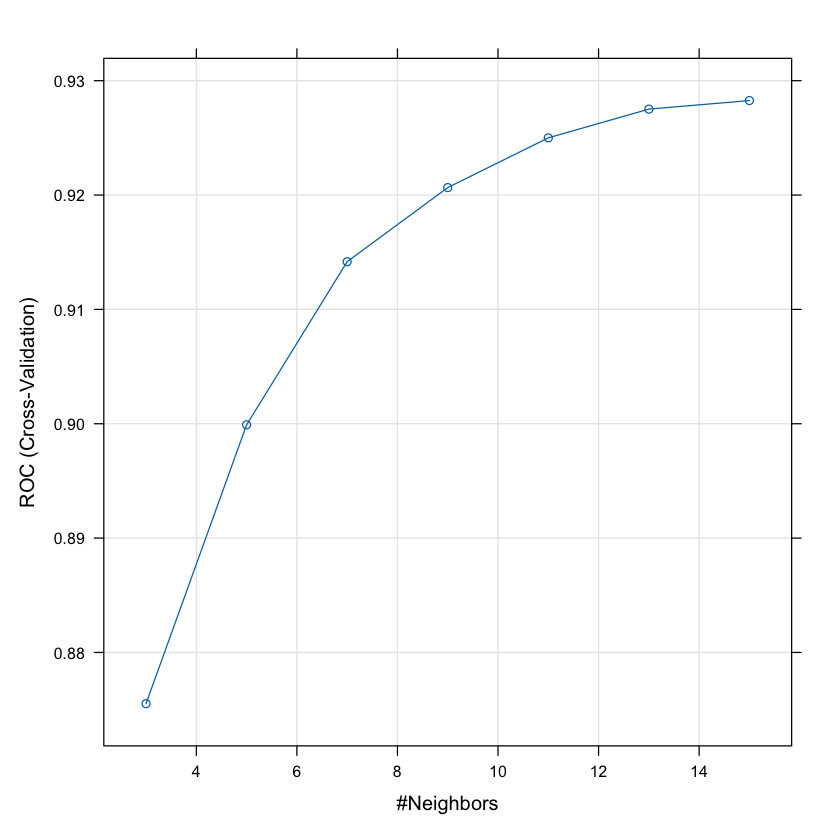

In [82]:
# Scale training and testing data
preproc <- preProcess(train_data[, predictors], method = c("center", "scale"))
train_scaled <- predict(preproc, train_data)
test_scaled <- predict(preproc, test_data)

# Train KNN with cross-validation
set.seed(123)
ctrl <- trainControl(method = "cv", number = 5, 
                     classProbs = TRUE, 
                     summaryFunction = twoClassSummary)

knn_grid <- expand.grid(k = seq(3, 15, by = 2))

knn_model <- train(MetabolicSyndrome ~ BMI + Age + LogBloodGlucose + HDL + WaistCirc + LogTriglycerides,
                   data = train_scaled,
                   method = "knn",
                   trControl = ctrl,
                   tuneGrid = knn_grid,
                   metric = "ROC")

print(knn_model)
plot(knn_model)

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  250  40
       Yes  35 114
                                          
               Accuracy : 0.8292          
                 95% CI : (0.7906, 0.8632)
    No Information Rate : 0.6492          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.6221          
                                          
 Mcnemar's Test P-Value : 0.6442          
                                          
            Sensitivity : 0.7403          
            Specificity : 0.8772          
         Pos Pred Value : 0.7651          
         Neg Pred Value : 0.8621          
             Prevalence : 0.3508          
         Detection Rate : 0.2597          
   Detection Prevalence : 0.3394          
      Balanced Accuracy : 0.8087          
                                          
       'Positive' Class : Yes             
                              

Setting levels: control = No, case = Yes

Setting direction: controls < cases



Area under the curve: 0.9029

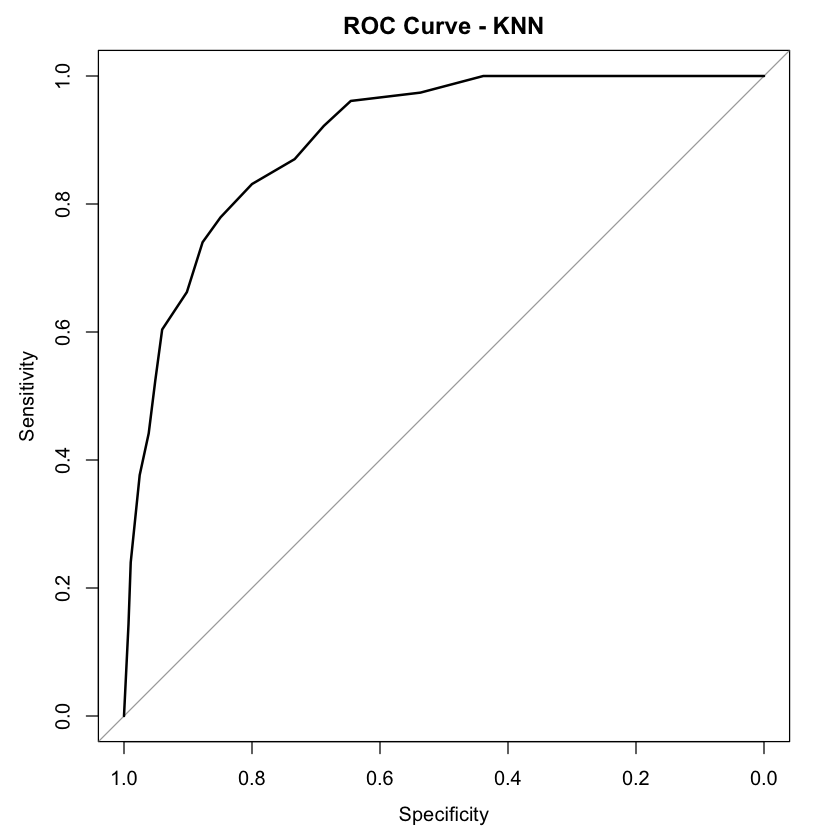

In [83]:
# Predictions and Confusion Matrix
knn_preds <- predict(knn_model, newdata = test_scaled)
confusionMatrix(knn_preds, test_scaled$MetabolicSyndrome, positive = "Yes")

# ROC Curve
knn_probs <- predict(knn_model, newdata = test_scaled, type = "prob")
knn_roc <- roc(response = test_scaled$MetabolicSyndrome,
               predictor = knn_probs$Yes)

plot(knn_roc, main = "ROC Curve - KNN")
auc(knn_roc)

Stochastic Gradient Boosting 

1762 samples
   6 predictor
   2 classes: 'No', 'Yes' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1410, 1409, 1409, 1411, 1409 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.trees  ROC        Sens       Spec     
  0.05       1                  100      0.9434193  0.9169425  0.7751639
  0.05       1                  150      0.9457345  0.9169425  0.7751639
  0.05       1                  200      0.9470622  0.9047001  0.7816286
  0.05       3                  100      0.9469895  0.9108251  0.7832153
  0.05       3                  150      0.9476862  0.9081935  0.8025964
  0.05       3                  200      0.9479524  0.9134375  0.7961317
  0.05       5                  100      0.9470924  0.9116908  0.7864149
  0.05       5                  150      0.9472124  0.9073125  0.7961448
  0.05       5                  200      0.9463139  0.9081859  0.8058484
  0.10       1            

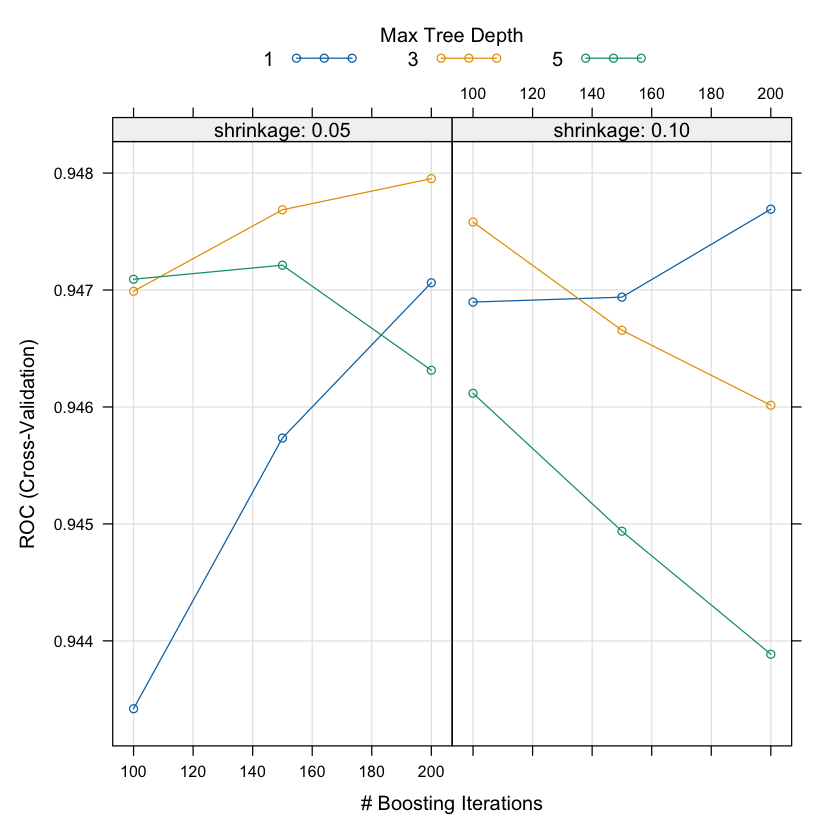

In [86]:
#Gradient Boosting (GBM)

# Train GBM model with tuning
set.seed(123)
gbm_grid <- expand.grid(interaction.depth = c(1, 3, 5),
                        n.trees = c(100, 150, 200),
                        shrinkage = c(0.05, 0.1),
                        n.minobsinnode = 10)

gbm_model <- train(MetabolicSyndrome ~ BMI + Age + LogBloodGlucose + HDL + WaistCirc + LogTriglycerides,
                   data = train_data,
                   method = "gbm",
                   trControl = ctrl,
                   tuneGrid = gbm_grid,
                   verbose = FALSE,
                   metric = "ROC")

print(gbm_model)
plot(gbm_model)

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  256  25
       Yes  29 129
                                          
               Accuracy : 0.877           
                 95% CI : (0.8426, 0.9062)
    No Information Rate : 0.6492          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.7315          
                                          
 Mcnemar's Test P-Value : 0.6831          
                                          
            Sensitivity : 0.8377          
            Specificity : 0.8982          
         Pos Pred Value : 0.8165          
         Neg Pred Value : 0.9110          
             Prevalence : 0.3508          
         Detection Rate : 0.2938          
   Detection Prevalence : 0.3599          
      Balanced Accuracy : 0.8680          
                                          
       'Positive' Class : Yes             
                              

Setting levels: control = No, case = Yes

Setting direction: controls < cases



Area under the curve: 0.95

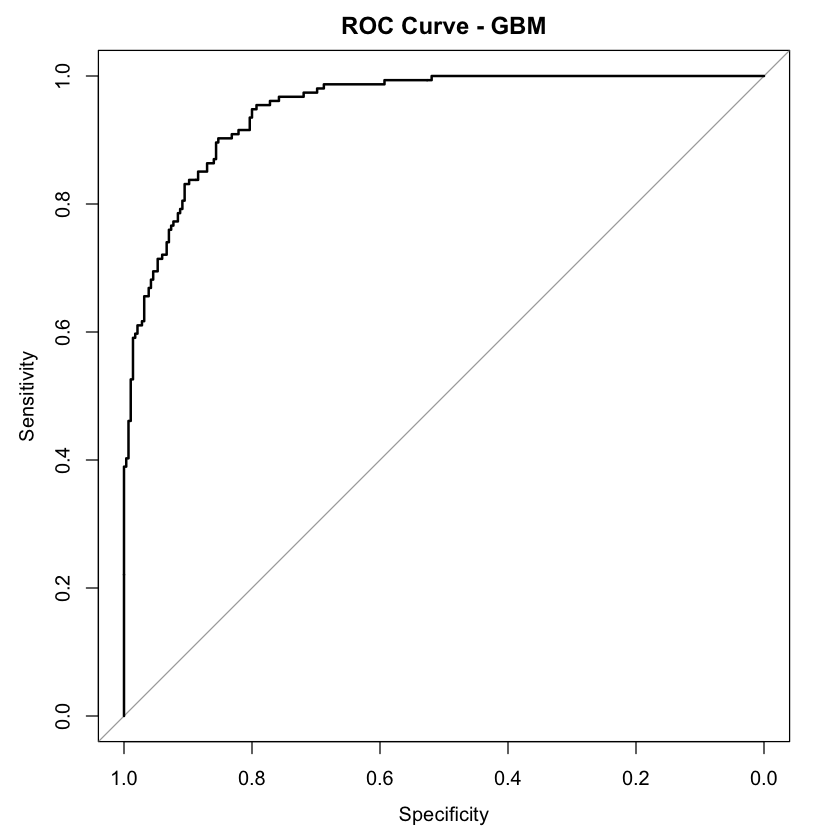

In [87]:
# Predictions and Confusion Matrix
gbm_preds <- predict(gbm_model, newdata = test_data)
confusionMatrix(gbm_preds, test_data$MetabolicSyndrome, positive = "Yes")

# ROC Curve
gbm_probs <- predict(gbm_model, newdata = test_data, type = "prob")
gbm_roc <- roc(response = test_data$MetabolicSyndrome,
               predictor = gbm_probs$Yes)

plot(gbm_roc, main = "ROC Curve - GBM")
auc(gbm_roc)

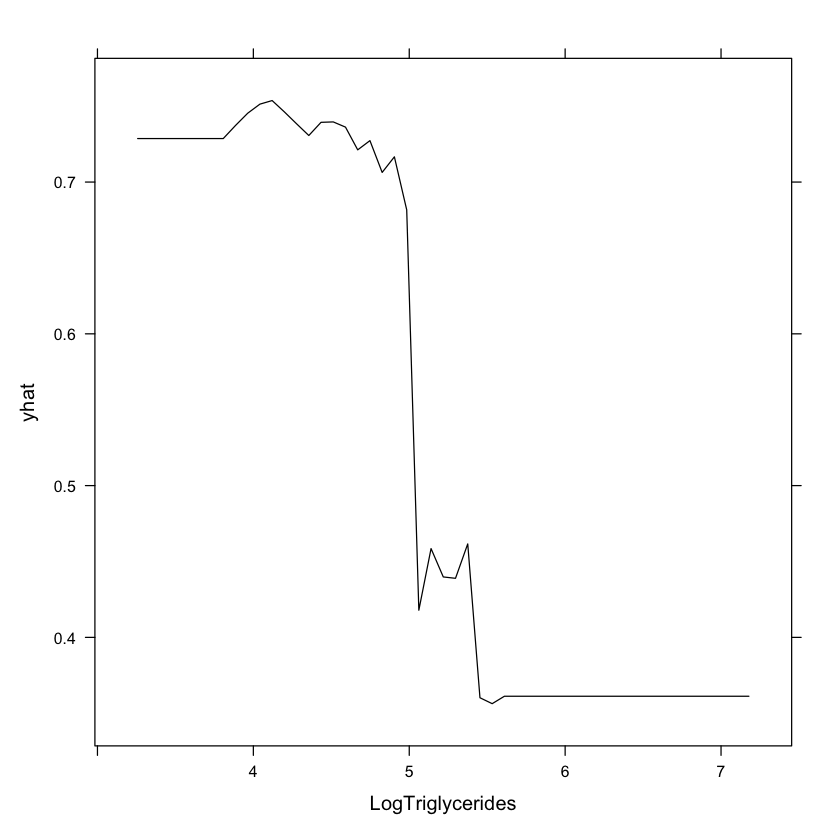

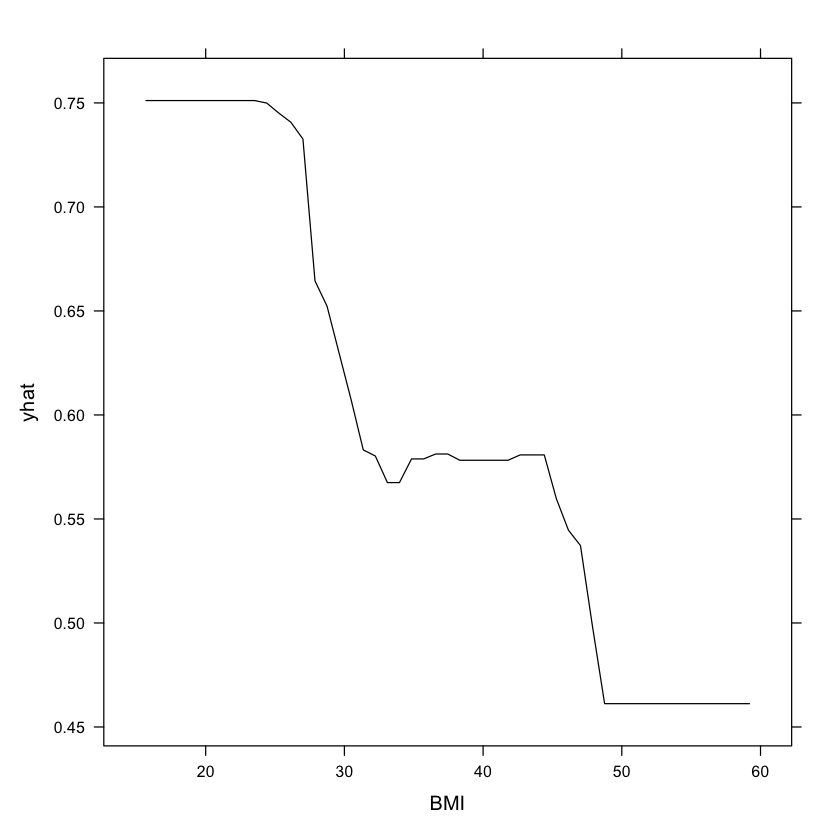

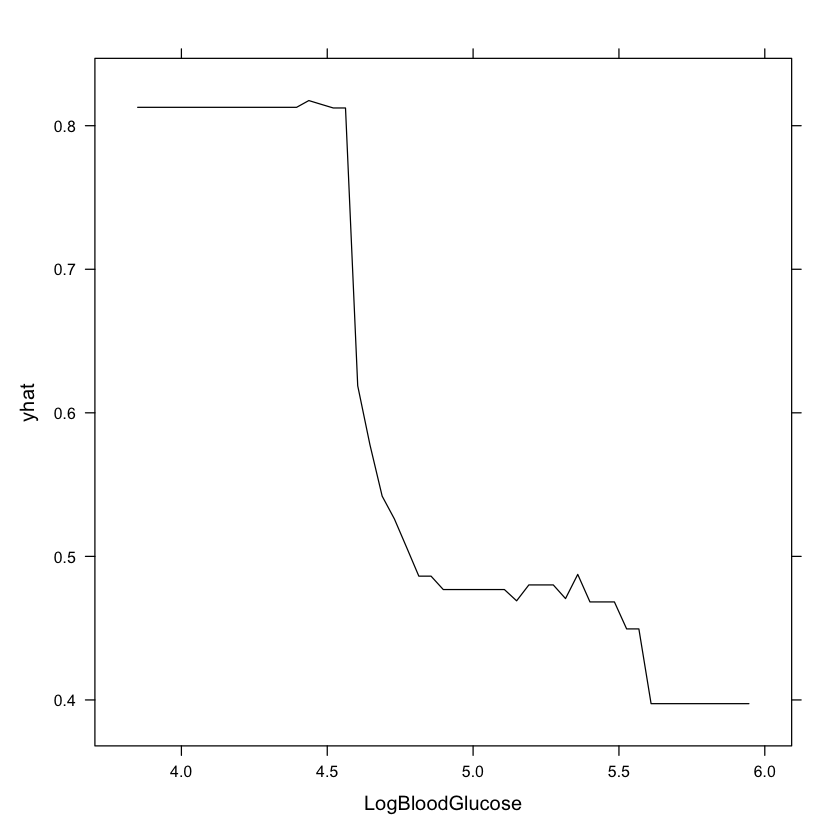

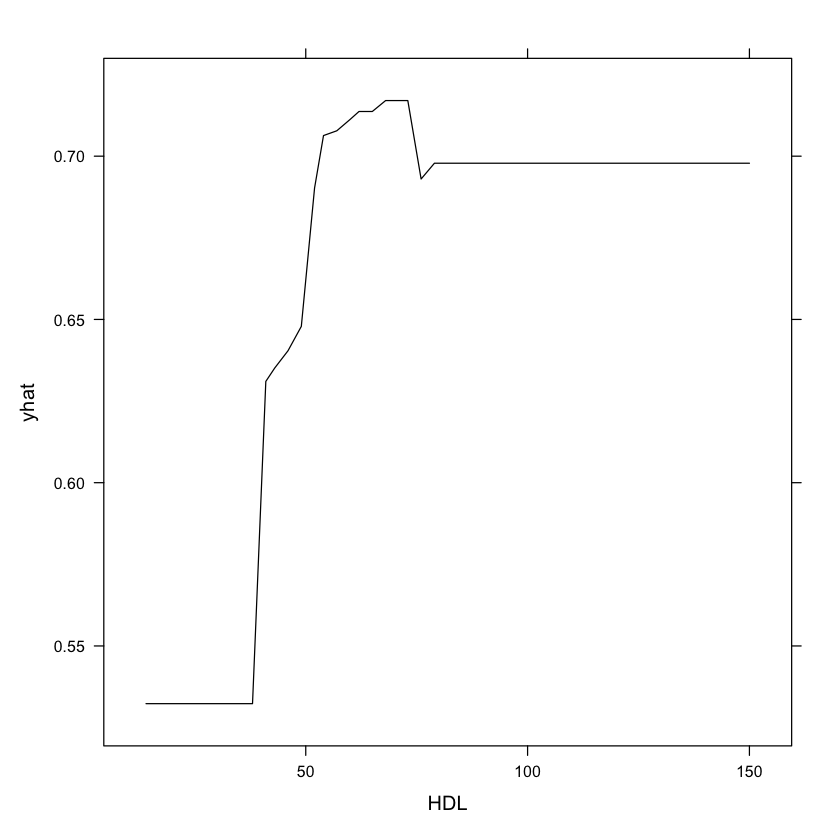

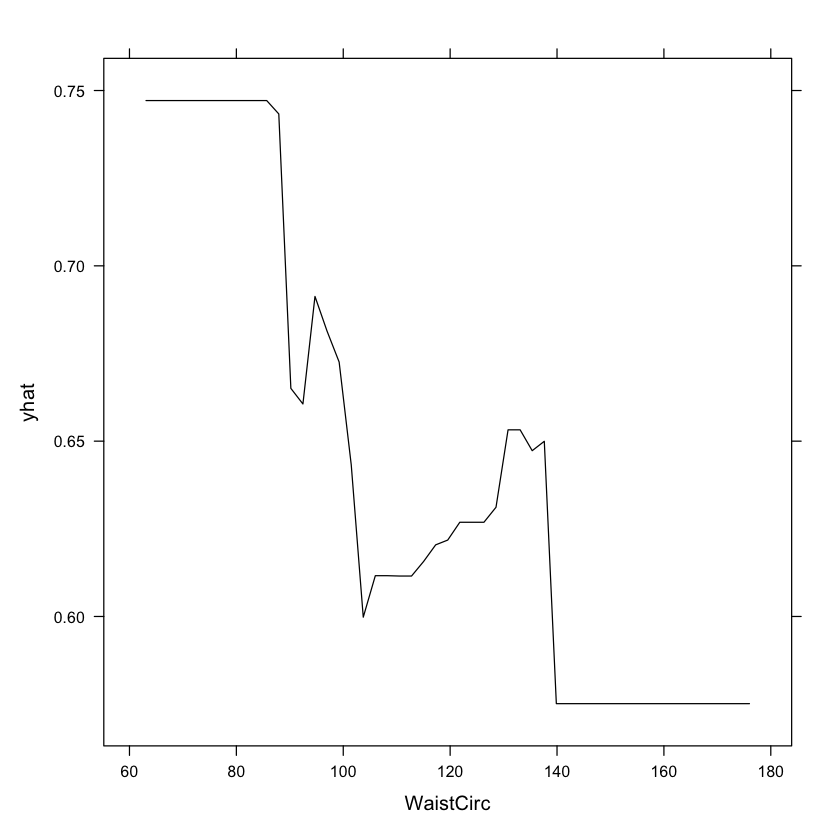

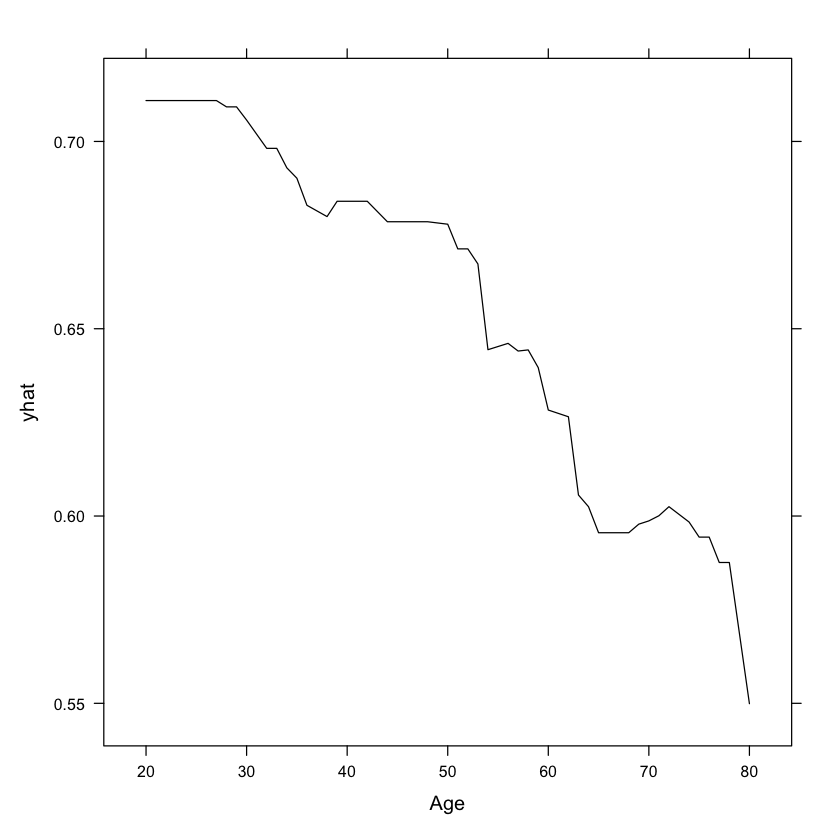

In [92]:
#To visualize the marginal effect of individual prectors, we are using Partial Dependence Plots

# PDP for LogTriglycerides (using final GBM model)
partial(gbm_model, pred.var = "LogTriglycerides", prob = TRUE, plot = TRUE)

# PDP for BMI
partial(gbm_model, pred.var = "BMI", prob = TRUE, plot = TRUE)

# PDP for LogBloodGlucose
partial(gbm_model, pred.var = "LogBloodGlucose", prob = TRUE, plot = TRUE)

# PDP for HDL
partial(gbm_model, pred.var = "HDL", prob = TRUE, plot = TRUE)

# PDP for Waist Circumference
partial(gbm_model, pred.var = "WaistCirc", prob = TRUE, plot = TRUE)

# PDP for Age
partial(gbm_model, pred.var = "Age", prob = TRUE, plot = TRUE)

In [93]:
#side-by-side bar chart for random forest and GBM models

# Get variable importance from Random Forest
rf_varimp <- importance(rf_model)
rf_importance_df <- data.frame(Variable = rownames(rf_varimp),
                               Importance = rf_varimp[, "MeanDecreaseGini"])
rf_importance_df$Model <- "Random Forest"

In [94]:
# Get variable importance from GBM
gbm_varimp <- summary(gbm_model, plotit = FALSE)
colnames(gbm_varimp) <- c("Variable", "Importance")
gbm_varimp$Model <- "GBM"

In [95]:
# Combine both into one data frame
importance_combined <- rbind(rf_importance_df, gbm_varimp)

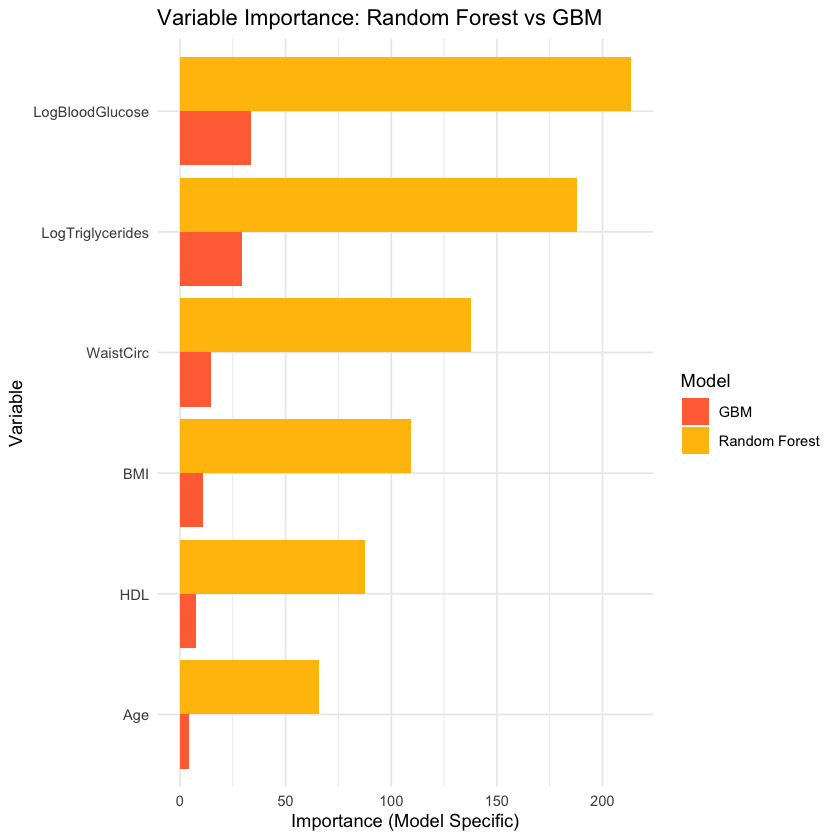

In [96]:
ggplot(importance_combined, aes(x = reorder(Variable, Importance), y = Importance, fill = Model)) +
  geom_bar(stat = "identity", position = "dodge") +
  coord_flip() +
  labs(title = "Variable Importance: Random Forest vs GBM",
       x = "Variable",
       y = "Importance (Model Specific)",
       fill = "Model") +
  theme_minimal() +
  scale_fill_manual(values = c("Random Forest" = "#FFC107", "GBM" = "#FF7043"))

In [97]:
gbm_varimp <- summary(gbm_model, plotit = FALSE)
colnames(gbm_varimp) <- c("Variable", "Importance")

In [98]:
saveRDS(gbm_varimp, file = "gbm_varimp.rds")

In [99]:
saveRDS(gbm_model, file = "gbm_model.rds")

In [100]:
save(gbm_model, file = "gbm_model.RData")